# Scenarios of Confounding

## Introduction

In this notebook we experimentally review some representative scenarios of *confounding*. The concept of confounders is an important tool to understand data and give it a causal interpretation. Here, we will take our start from the fun and illustrative case study of the greedy casino designed in [Bareinboim2015]. We implement and study this scenario, and then move onto other famous and representative case studies, which we use to exemplify and expound important ideas related to confounders and causality.

1. *Greedy casino*: we start with the greedy casino, a scenario affected by (quasi-)hidden confounders. We perform observational and interventional studies, obtaining different results because of the confounders. Contrary to the possible expectation that exact interventional quantities are preferrable, this scenario shows that our specific concerns rule which quantity is to be preferred. Furthermore discrepancy between the observed and interventional quantities induces us to suspect unethical behaviour.

2. *Ungreedy casino:* we consider a second casino, in which no confounders are present. Observational and interventional studies produce again diverging results, which are not distinguishable from the greedy casino case. This hints to the fact that our discussion of ethical evaluation may not depend only on the existence of confounders, but it requires deeper considerations.

3. *Effectiveness of a new medicine*: we then move (by graphical analogy) to the standard case of evaluating the effectiveness of a new medicine. This is a standard scenario which may be found in classical causality texts like [Pearl2009]. Here, we deal with a hidden confounder. Again, we perform observational and interventional studies, which end up disagreeing because of the unobserved confounder. In this case, interventional quantities provide the measure of causal strenght (ATE) we are looking for.

4. *Policymaking for a new medicine*: we keep playing with the new medicine scenario, wondering whether the interventional studies we have made are sufficient to justify the adoption of a determined policy. The realization that the simple knowledge of the causal effect of a medicine is not enough to find an optimal policy leads us to consider how other quantities (CATE, counterfactuals) allow us to work around confounders.

5. *Simpson's paradox: effectiveness of a new medicine*: we trace back to our question about the effectiveness of a new medicine, and we provide a new interpretation for the discrepancy between observational and interventional results. In particular, we show how wrong causal statements may be explained by a misspecified causal model; inconsistencies may arise among interventional quantities estimated via do-calculus on a model that misspecifies or ignores confounders.

6. *Simpson's paradox: university admission*: we finish with a classical instance of Simpson's paradox. Here, we deal with an observable confounder. Apparent inconsistencies arise even among observational data as a consequence of dealing improperly with confounders and causal interpretations.

We conclude with a few appendices where we provide a few variations of the scenarios that we examined.

This notebooks assumes basic knowledge of causality and structural causal models (SCMs) [Pearl2009].

## Setup

Let us start by importing a couple of generic libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from tqdm import tqdm

We then define the number of simulations in our experiments.

In [2]:
n_trials = 10000

Finally, we set a random seed for reproducibility.

In [3]:
np.random.seed(1985)

# Greedy casino

Let us re-implement and explore the model of the *greedy casino* presented in [Bareinboim2015], and let's play around with it.

## Scenario

Welcome to the Greedy Casino! [Bareinboim2015] 

In the greedy casino, players interact with sneaky slot machines that set their reward probability according to the state of the players. In the scenario we assume that it is well known that the choices of players are affected by: (a) their level of drunkedness, and (b) whether a slot machine is blinking or not. The sneaky machines in the greedy casino are equipped with cameras and face detection software, and they will set their reward probability as a function of the drunkedness of the player and level of blinking of the machine itself.

Formally, we set up a *2-armed bandits with unobserved confounders*: a machine (*bandit*) has two levers (*2-armed*); the choice ($X$) of the player and the outcome ($Y$) are affected by drunkedness and blinking (*unobserved confounders*).  

The problem we want to consider here is whether the reward levels of the machines are within the parameters of the law, that is, whether the percentage of victories is sufficently high. We will take $0.3$ as the required threshold, meaning that at least 3 times out of 10 the machines are expected to reward the players.

This investigation will lead us to discover a discrepancy between the expected reward in an *observational setting* and the expected reward in an *interventional setting*. We will explain this discrepancy in terms of different underlying structural causal models.

## Implementation

Let us take a computational approach and build a simulation of our casino. We use the concrete model presented in [Bareinboim2015].

We start with two functions, one randomly defining the state of a player (0: *sober*, 1: *drunk*) and one randomly defining the state of a machine (0: *subdued*, 1: *blinking*).  

In [4]:
def random_select_blinking():
    return np.random.binomial(1,p=.5)

def random_select_drunkedness():
    return np.random.binomial(1,p=.5)

We then introduce a sneaky function that determines the reward level of the machine exploiting knowledge of the drunkedness of the player and blinking of the machine. Notice that we return an array: since every machine has two levers (*2-arms*) the first value is the winning probability when pulling the first arm, and the second is the winning probability when pulling the second arm.

In [5]:
def sneaky_select_reward(blinking,drunkedness):
    if drunkedness==0:
        if blinking==0:
            return np.array([.1,.5])
        else:
            return np.array([.5,.1])
    else:
        if blinking==0:
            return np.array([.4,.2])
        else:
            return np.array([.2,.4])

Finally, we define the play function which returns the outcome of playing (0: *loss*, 1: *victory*) taking into consideration the reward probability and the chosen lever. 

In [6]:
def play(lever,reward):
    return np.random.binomial(1,reward[int(lever)])

## Observational study

In order to get an intuition on whether the casino complies with the law, we run an *observational study*. We track players and record their results.

As the managers of the casino have understood, the choice of which lever to play is not completely random. The *natural* choice of a player depends on her level of drunkedness and the blinking of the machine. We encode this function next (0: *first lever*, 1: *second lever*):

In [7]:
def observational_select_lever(blinking,drunkedness):
    return np.logical_xor(blinking,drunkedness)

We define a function representing a set of *observations* (generating the player and the machine, setting the reward, choosing which arm to pull, playing) and we collect the outcomes.

In [8]:
def run_observational_simulation(n_trials=n_trials):
    
    results = {'lever': np.zeros(n_trials), 
               'outcome': np.zeros(n_trials)}
    
    for i in tqdm(range(n_trials)):
        blinking = random_select_blinking()
        drunkedness = random_select_drunkedness()
        
        reward = sneaky_select_reward(blinking,drunkedness)
                
        lever = observational_select_lever(blinking,drunkedness)
            
        outcome = play(lever,reward)
        
        results['lever'][i] = lever
        results['outcome'][i] = outcome
    
    return results

As good statisticians, we collect many samples.

In [9]:
obs_res = run_observational_simulation()

100%|█████████████████████████████████| 10000/10000 [00:00<00:00, 178230.74it/s]


We look then at the probability of victory $P(Y=1)$, where $Y$ is the outcome.

In [10]:
print('Probability of victory: {0}'.format(np.sum(obs_res['outcome']==1) / len(obs_res['outcome'])))

Probability of victory: 0.1442


The probability is very low, way under the legal threshold of $0.3$, suggesting that the casino is doing something fishy.

This is confirmed also by conditioning on the chosen lever. Let us compute $P(Y=1 \vert X=0)$ and $P(Y=1 \vert X=1)$ where $X$ is the chosen lever.

In [11]:
n_victory_lever0 = np.sum(obs_res['outcome'][obs_res['lever']==0])
n_lever0 = np.sum(obs_res['lever']==0)

print('Probability of victory given lever 0: {0}'.format(n_victory_lever0 / n_lever0))

Probability of victory given lever 0: 0.147192118226601


In [12]:
n_victory_lever1 = np.sum(obs_res['outcome'][obs_res['lever']==1])
n_lever1 = np.sum(obs_res['lever']==1)

print('Probability of victory given lever 1: {0}'.format(n_victory_lever1 / n_lever1))

Probability of victory given lever 1: 0.14111675126903553


Both results confirm that something illegal may be going on.

Let us stop for a moment and try to provide a graphical representation of our model. 

**Computational graph.** We will first draw out an intuitive computational graph of our scenario.

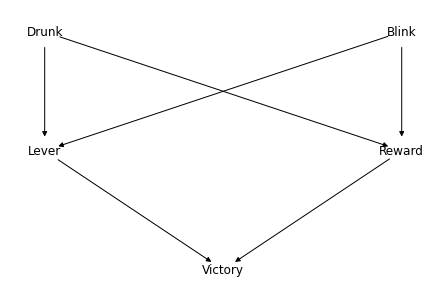

In [13]:
G = nx.DiGraph()
G.graph['dpi'] = 120

nodes = ['X', 'Y', 'Z1', 'Z2', 'r',]
edges = [('Z1','X'), ('Z2','X'), ('Z1','r'), ('Z2','r'), ('X','Y'),('r','Y')]
nodes_pos = {'Z1':(-1, 1), 'Z2':(1, 1), 'X':(-1, -1), 'r':(1, -1), 'Y':(0, -3)}
nodes_lbl = {'Z1':'Drunk', 'Z2':'Blink', 'X':'Lever', 'r':'Reward', 'Y':'Victory'}

G.add_nodes_from(nodes)
G.add_edges_from(edges)
nx.draw(G,nodes_pos,node_size=800,node_color='white')
_ = nx.draw_networkx_labels(G,nodes_pos,nodes_lbl)

We have here a 1-to-1 correspondance between nodes and functions:
- *drunk* $\rightarrow$ *random_select_drunkedness()*
- *blink* $\rightarrow$ *random_select_blinking()*; 
- *lever* $\rightarrow$ *sneaky_select_reward(blinking,drunkedness)*; 
- *reward* $\rightarrow$ *observational_select_lever(blinking,drunkedness)*;
- *victory* $\rightarrow$ *play(lever,reward)*.

Notice how the arrows capture the arguments of the functions.

**SCM graph.** We can actually turn the above intuitive computational graph into a rigorous *structural causal model* (SCM) [Pearl2009] defined by a set of exogenous variables $\mathcal{E}$, a set of endogenous variables $\mathcal{X}$, a set of structural functions $\mathcal{F}$ associated with the endogenous variables, and a set of probability distribution $\mathcal{P}$ associated with the exogenous variables.

Let us redefine the nodes of our graph as follows:

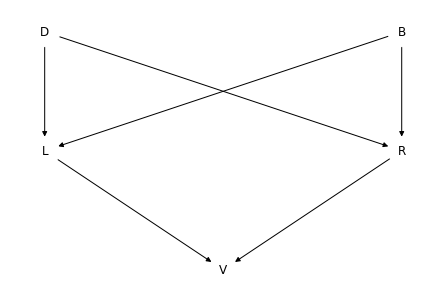

In [14]:
G = nx.DiGraph()
G.graph['dpi'] = 120

nodes = ['X', 'Y', 'Z1', 'Z2', 'r',]
edges = [('Z1','X'), ('Z2','X'), ('Z1','r'), ('Z2','r'), ('X','Y'),('r','Y')]
nodes_pos = {'Z1':(-1, 1), 'Z2':(1, 1), 'X':(-1, -1), 'r':(1, -1), 'Y':(0, -3)}
nodes_lbl = {'Z1':'D', 'Z2':'B', 'X':'L', 'r':'R', 'Y':'V'}

G.add_nodes_from(nodes)
G.add_edges_from(edges)
nx.draw(G,nodes_pos,node_size=800,node_color='white')
_ = nx.draw_networkx_labels(G,nodes_pos,nodes_lbl)

where the set of endogenous variables is: $$ \mathcal{X} = \{ D,B,L,R,V \}, $$ with obvious meanings, the set of exogenous variables (not depicted) is: $$ \mathcal{E} = \{ U_D,U_B,U_L,U_R,U_V \}, $$ the set of probability distributions $\mathcal{P}$ is made up by:
\begin{align*}
U_{D} & \sim\mathtt{Bern}(.5)\\
U_{B} & \sim\mathtt{Bern}(.5)\\
U_{R} & \sim\mathtt{1}\\
U_{L} & \sim\mathtt{1}\\
U_{V} & \sim\mathtt{Unif}(0,1)
\end{align*}
where $\mathtt{Bern}(p)$ is a Bernoulli distribution with probability $p$, $\mathtt{Unif}(a,b)$ is a continuous uniform distribution between $a$ and $b$, and $\mathtt{1}$ is just an identity,
and the set of structural functions $\mathcal{F}$ is defined by:
\begin{align*}
D & =f_{D}(U_{D})=U_{D}\\
B & =f_{B}(U_{B})=U_{B}\\
R & =f_{R}(D,B,U_{R})=\mathtt{if...}\\
L & =f_{L}(D,B,U_{L})=D\oplus B\\
V & =f_{V}(T,R,U_{V})=\mathtt{if...}
\end{align*}
where $\mathtt{if...}$ is a shorthand for the if-statement encoded in the respective functions.

**Simplified SCM graph.** Notice that the node $R$ defining the reward probability of each level has no stochastic component (indeed $U_R \sim \mathtt{1}$) and just performs a deterministic computation. Instead of performing this computation in the node $R$, we can forward the inputs and integrate the computation directly in $V$, obtaining the smaller model:

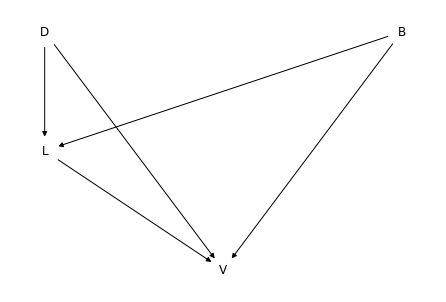

In [15]:
G = nx.DiGraph()
G.graph['dpi'] = 120

nodes = ['X', 'Y', 'Z1', 'Z2']
edges = [('Z1','X'), ('Z2','X'), ('Z1','Y'), ('Z2','Y'), ('X','Y')]
nodes_pos = {'Z1':(-1, 1), 'Z2':(1, 1), 'X':(-1, -1), 'Y':(0, -3)}
nodes_lbl = {'Z1':'D', 'Z2':'B', 'X':'L', 'Y':'V'}

G.add_nodes_from(nodes)
G.add_edges_from(edges)
nx.draw(G,nodes_pos,node_size=800,node_color='white')
_ = nx.draw_networkx_labels(G,nodes_pos,nodes_lbl)

This model has a very familiar shape; using standard causality notation and lexicon we can identify a *treatment* node ($X$), an *outcome* node ($Y$), and two confounders ($Z_1, Z_2$):

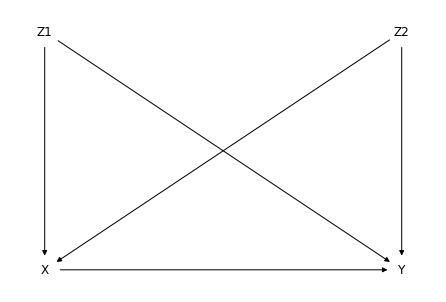

In [16]:
G = nx.DiGraph()
G.graph['dpi'] = 120

nodes = ['X', 'Y', 'Z1', 'Z2']
edges = [('Z1','X'), ('Z2','X'), ('Z1','Y'), ('Z2','Y'), ('X','Y')]
nodes_pos = {'Z1':(-1, 1), 'Z2':(0, 1), 'X':(-1, -1), 'Y':(0, -1)}
nodes_lbl = {'Z1':'Z1', 'Z2':'Z2', 'X':'X', 'Y':'Y'}

G.add_nodes_from(nodes)
G.add_edges_from(edges)
nx.draw(G,nodes_pos,node_size=800,node_color='white')
_ = nx.draw_networkx_labels(G,nodes_pos,nodes_lbl)

A couple of observations:

1. The reasoning we have used to eliminate the node $R$ could be used to eliminate the node $L$, as well. The choice of the lever is purely deterministic. The reason we do not want to eliminate $L$ is that we will *intervene* on this node later.

2. The presence of *two* confounders $Z_1,Z_2$ is not necessary. A 'greedy casino' may be set up with a single confounder (see *one-confounder example* in the Appendix).

## Experimental study

Let us go back to our scenario. Tipped by our recordings, public officers are now coming over to validate our complaint against the casino. Following statistical good practices they run an *experimental* study. They pick a customer and they assign her a random lever to pull.

We represent this scenario with a function in which the chosen lever is not the result of a *natural* choice encoded in a function, but a random toss of a coin.

In [17]:
def interventional_select_lever():
    return np.random.binomial(1,p=.5)

We define a function representing a set of *experiments* (generating the player and the machine, setting the reward, randomly choosing which arm to pull, playing) and we collect the outcomes.

In [18]:
def run_interventional_simulation(n_trials=n_trials):
    
    results = {'lever': np.zeros(n_trials), 
               'outcome': np.zeros(n_trials)}
    
    for i in tqdm(range(n_trials)):
        blinking = random_select_blinking()
        drunkedness = random_select_drunkedness()
        
        reward = sneaky_select_reward(blinking,drunkedness)
        
        lever = interventional_select_lever()    
        
        outcome = play(lever,reward)
        
        results['lever'][i] = lever
        results['outcome'][i] = outcome
    
    return results

As before, we collect many samples.

In [19]:
int_res = run_interventional_simulation()

100%|█████████████████████████████████| 10000/10000 [00:00<00:00, 163073.68it/s]


Looking at the probability of victory, it seems the casino is doing an okay job, having a winning percentage close within the threshold required by law (up to sampling error).

In [20]:
print('Probability of victory: {0}'.format(np.sum(int_res['outcome']==1) / len(int_res['outcome'])))

Probability of victory: 0.303


Beware that the estimated quantity is not $P(Y=1)$ but $P_{do(X=x)}(Y=1) = P(Y=1 \vert do(X=x)) $, that is, the probability of victory in the model in which we intervened on the choice of the lever.

A similar conclusion follows by computing probabilities for individual levers:

In [21]:
n_victory_lever0 = np.sum(int_res['outcome'][int_res['lever']==0])
n_lever0 = np.sum(int_res['lever']==0)

print('Probability of victory acting on lever 0: {0}'.format(n_victory_lever0 / n_lever0))

Probability of victory acting on lever 0: 0.3046623794212219


In [22]:
n_victory_lever1 = np.sum(int_res['outcome'][int_res['lever']==1])
n_lever1 = np.sum(int_res['lever']==1)

print('Probability of victory acting on lever 1: {0}'.format(n_victory_lever1 / n_lever1))

Probability of victory acting on lever 1: 0.3013535031847134


Again, beware that these quantities are not the *observational conditionals* $P(Y=1 \vert X=0)$ and $P(Y=1 \vert X=1)$, but the *interventionals* $P(Y=1 \vert do(X=0))$ and $P(Y=1 \vert do(X=1))$

Let us try to understand what the officials have done, and why their results substantially differ from the results we colelcted.

**Computational graph.** Let us first compare the officials' computational graph with ours.

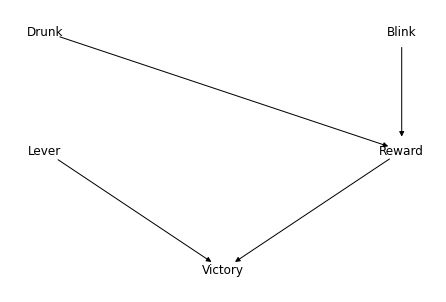

In [23]:
G = nx.DiGraph()
G.graph['dpi'] = 120

nodes = ['X', 'Y', 'Z1', 'Z2', 'r',]
edges = [('Z1','r'), ('Z2','r'), ('X','Y'),('r','Y')]
nodes_pos = {'Z1':(-1, 1), 'Z2':(1, 1), 'X':(-1, -1), 'r':(1, -1), 'Y':(0, -3)}
nodes_lbl = {'Z1':'Drunk', 'Z2':'Blink', 'X':'Lever', 'r':'Reward', 'Y':'Victory'}

G.add_nodes_from(nodes)
G.add_edges_from(edges)
nx.draw(G,nodes_pos,node_size=800,node_color='white')
_ = nx.draw_networkx_labels(G,nodes_pos,nodes_lbl)

The graph is the same as before with the exception of one node/function:
- *lever* $\rightarrow$ *interventional_select_lever()*.

Since the function associated with *lever* has no arguments, the node has no incoming arrows.

**SCM graph.** Let us translate the computational graph into a SCM:

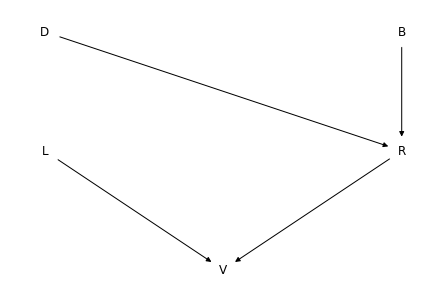

In [24]:
G = nx.DiGraph()
G.graph['dpi'] = 120

nodes = ['X', 'Y', 'Z1', 'Z2', 'r',]
edges = [('Z1','r'), ('Z2','r'), ('X','Y'),('r','Y')]
nodes_pos = {'Z1':(-1, 1), 'Z2':(1, 1), 'X':(-1, -1), 'r':(1, -1), 'Y':(0, -3)}
nodes_lbl = {'Z1':'D', 'Z2':'B', 'X':'L', 'r':'R', 'Y':'V'}

G.add_nodes_from(nodes)
G.add_edges_from(edges)
nx.draw(G,nodes_pos,node_size=800,node_color='white')
_ = nx.draw_networkx_labels(G,nodes_pos,nodes_lbl)

where the set of endogenous variables $\mathcal{X}$ and exogenous variables $\mathcal{E}$ are the same, the set of probability distributions $\mathcal{P}$ is identical with the exception of:
\begin{align*}
U_{L} & \sim\mathtt{Bern}(.5),\\
\end{align*}
and similarly the set of structural functions $\mathcal{F}$ is the same except for:
\begin{align*}
L & =f_{L}(D,B,U_{L})=U_{L}.\\
\end{align*}
This represents what we would normally refer to as the *post-interventional* model in which the incoming arrows on the intervened nodes have been removed.

**Simplified SCM graph.** Simplifying the model as we did before, we get:

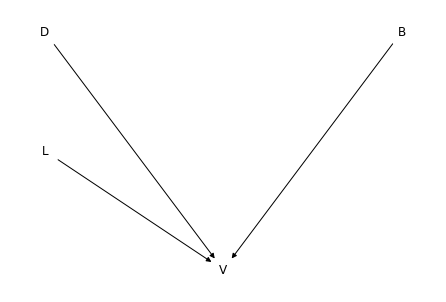

In [25]:
G = nx.DiGraph()
G.graph['dpi'] = 120

nodes = ['X', 'Y', 'Z1', 'Z2']
edges = [('Z1','Y'), ('Z2','Y'), ('X','Y')]
nodes_pos = {'Z1':(-1, 1), 'Z2':(1, 1), 'X':(-1, -1), 'Y':(0, -3)}
nodes_lbl = {'Z1':'D', 'Z2':'B', 'X':'L', 'Y':'V'}

G.add_nodes_from(nodes)
G.add_edges_from(edges)
nx.draw(G,nodes_pos,node_size=800,node_color='white')
_ = nx.draw_networkx_labels(G,nodes_pos,nodes_lbl)

and in standard causality notation:

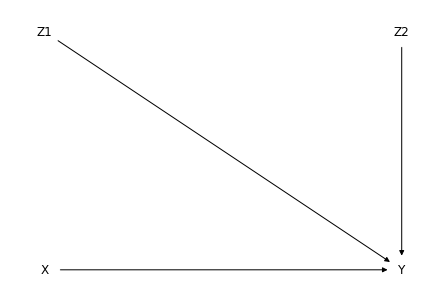

In [26]:
G = nx.DiGraph()
G.graph['dpi'] = 120

nodes = ['X', 'Y', 'Z1', 'Z2']
edges = [('Z1','Y'), ('Z2','Y'), ('X','Y')]
nodes_pos = {'Z1':(-1, 1), 'Z2':(0, 1), 'X':(-1, -1), 'Y':(0, -1)}
nodes_lbl = {'Z1':'Z1', 'Z2':'Z2', 'X':'X', 'Y':'Y'}

G.add_nodes_from(nodes)
G.add_edges_from(edges)
nx.draw(G,nodes_pos,node_size=800,node_color='white')
_ = nx.draw_networkx_labels(G,nodes_pos,nodes_lbl)

## Recap: Observational vs experimental results

Through our graphical modelling we can explain the discrepancy between our results and the results collected by the state officials. Notice that this discrepancy can be maximized by the casino owner as shown in the *maximally greedy casino example* in the Appendix.

**What is the meaning of the observational results?**
Our results were collected in an observational setting, that is a scenario in which *treatment* (lever) and *outcome* (victory) were confounded.

What we observed was $P(Y=1 \vert X=x)$, that is, what is the probability for a customer to go out of the casino with a reward in the natural setting, without us doing anything.

**What is the meaning of the interventional results?**
The results collected by the state officials came from an interventional setting; by requiring the players to choose a lever completely at random they broke the connection between the *confounders* (drunkedness, blinking) and *treatment* (lever). They then collected results form a world in which *treatment* (lever) and *outcome* (victory) are not confounded anymore.

What they observed was $P(Y=1 \vert do(X=x))$, that is, probability for a customer to go out of the casino with a reward if a certain choice is taken, or imposed, independently from any other factor.

**What is the point of performing an interventional study?**
Notice that the interventional study makes perfect sense if the aim is to characterize the *causal* mechanism of the outcome $Y$ as a function of $X$. The state officials do indeed observe the *true* distribution of the reward as a simple function of the chosen lever: the average reward, for any choice of lever, is $0.3$, as we encoded in our program. The state officials recovered that value. So the actual *causal dynamics* between treatment and outcome is reconstructed. What is missed is the fact that, because of external factors, the distribution of choice of the lever has a particular distribution; and knowledge of the factors that affect this distribution are exploited by the casino managers to trick their customers. 

Indeed, from another perspective, we can explain the interventional study as a way to make the distribution for each $X=x$ identical: we do not want our assessment of the causal link $X\rightarrow Y$ to be affected by a different distribution at different levels $X=x$. By making the population for each $X=x$ identical, we retrieve the *causal effect*, but we lose the fact that, because of such a difference, the proportion of players leaving the casino winning is lower than $0.3$.

# Ungreedy casino

The above scenario may suggest that the discrepancy behind the observational quantity and the interventional quantity *implies* in itself that something unethical is being done by the casino managers. However, the judgement of fairness does not necessarily proceeds from the numbers that we collected. Let's explore an alternative scenario. We will see that our conclusions have to be based on a graphical model, and, therefore, on our assumption on the role of confounders.

## Scenario

After our unhappy experience at the greedy casino, we decide to move on to the nearby assuredly ungreedy casino.
In this new gaming hall, it is guaranteed that rewards are selected randomly independently from any invasive analysis of the traits of the clients or any other environmental signal. However, it happens that drunk players normally opt for the unlucky lever; and it also happens that drunk players are more numerous that sober one.

Formally, we still have a *2-armed bandits* problem: a machine (*bandit*) with two levers (*2-armed*); the choice ($X$) of the player is affected by drunkedness ($Z$); the outcome ($Y$) is affected only by the chosen lever. We can represent the scenario with the following graph:

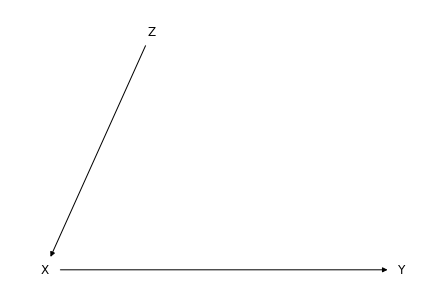

In [27]:
G = nx.DiGraph()
G.graph['dpi'] = 120

nodes = ['X', 'Y', 'Z']
edges = [('Z','X'), ('X','Y')]
nodes_pos = {'Z':(-.7, 1), 'X':(-1, -1), 'Y':(0, -1)}
nodes_lbl = {'Z':'Z', 'X':'X', 'Y':'Y'}

G.add_nodes_from(nodes)
G.add_edges_from(edges)
nx.draw(G,nodes_pos,node_size=800,node_color='white')
_ = nx.draw_networkx_labels(G,nodes_pos,nodes_lbl)

Again, we want to evaluate if the ungreedy casino complies with the legal prescription of having a winning percentage of at least $0.3$.

## Implementation

We implement this scenario following the same structure we used for the greedy casino.

In [28]:
def random_select_drunkedness():
    return np.random.binomial(1,p=.1)

def random_select_reward():
    return np.array([.2,.4])

def observational_select_lever(drunkedness):
    return drunkedness

def interventional_select_lever():
    return np.random.binomial(1,p=.5)
    
def play(lever,reward):
    return np.random.binomial(1,reward[int(lever)])

We have similarly named functions, but notice how arguments changed; in particular the *select_reward()* function (which has been aptly re-characterized as *random* instead of *sneaky*) receives no input, consistently with it having no incoming arrow in the graph above.  

## Observational study

We can now perform an observational study as before:

In [29]:
def run_observational_simulation(n_trials=n_trials):
    
    results = {'x': np.zeros(n_trials),
               'z': np.zeros(n_trials),
               'y': np.zeros(n_trials)}
    
    for i in tqdm(range(n_trials)):
        drunkedness = random_select_drunkedness()
        reward = random_select_reward()
        lever = observational_select_lever(drunkedness)
        victory = play(lever,reward)
        
        results['x'][i] = lever
        results['z'][i] = drunkedness
        results['y'][i] = victory
    
    return results

res = run_observational_simulation()
print('Probability of victory: {0}'.format(np.sum(res['y']==1) / len(res['y'])))

100%|█████████████████████████████████| 10000/10000 [00:00<00:00, 271303.90it/s]

Probability of victory: 0.2155


## Experimental study

Similarly, we can call over state officials to perform an interventional study:

In [30]:
def run_interventional_simulation(n_trials=n_trials):
    
    results = {'x': np.zeros(n_trials),
               'z': np.zeros(n_trials),
               'y': np.zeros(n_trials)}
    
    for i in tqdm(range(n_trials)):
        drunkedness = random_select_drunkedness()
        reward = random_select_reward()
        lever = interventional_select_lever()
        victory = play(lever,reward)
        
        results['x'][i] = lever
        results['z'][i] = drunkedness
        results['y'][i] = victory
    
    return results

res = run_interventional_simulation()
print('Probability of victory: {0}'.format(np.sum(res['y']==1) / len(res['y'])))

100%|█████████████████████████████████| 10000/10000 [00:00<00:00, 205170.67it/s]

Probability of victory: 0.2923


The results we obtained look very similar to the one we observed at the greedy casino: there is a gap between observational and interventional quantities that casts doubts on the casino, albeit notoriously ungreedy.

## Recap: Fair vs unfair

Let us try to compare and understand the results at the greedy and ungreedy casino.

**Is the greedy casino unfair? How about the ungreedy casino?** Just looking at observational and interventional quantities seems impossible to distinguish between the greedy and the ungreedy casino, and thus cast a judgment about their fairness. An evaluation of fairness requires to understand how the discrepancy we observed is generated: in the greedy casino there is a sneaky function that takes (potentially illegal) advantage of side information, while in the ungreedy casino there is a purely random function that happens to combine positively (for the casino owner) with the state of the customers. Of course, it would be up to the owner of the ungreedy casino to prove that the random function is actually random and not intentionally set up to sneakily exploit previous knowledge about the distribution of customers.

Such a fairness judgement, which relies on the assumption that the reward levels are independent from the behaviour and distribution of drunkedness, requires knowledge of the graph (or more refined interventional studies that may assess the existence and strength of the arrow $Z \rightarrow Y$).

# Effectiveness of a new medicine

Let us now consider a very classic and basic *confounding* scenario.

## Scenario

We have seen above that the (observational) greedy casino scenario, stripped to its bare bones and reduced to a single confounder, may be represented by the following graph:

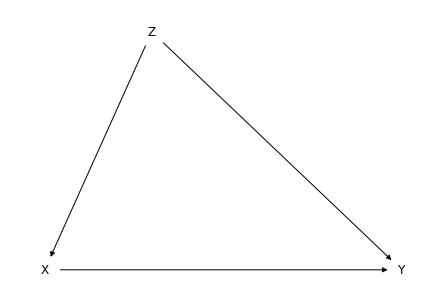

In [31]:
G = nx.DiGraph()
G.graph['dpi'] = 120

nodes = ['X', 'Y', 'Z']
edges = [('Z','X'), ('Z','Y'), ('X','Y')]
nodes_pos = {'Z':(-.7, 1), 'X':(-1, -1), 'Y':(0, -1)}
nodes_lbl = {'Z':'Z', 'X':'X', 'Y':'Y'}

G.add_nodes_from(nodes)
G.add_edges_from(edges)
nx.draw(G,nodes_pos,node_size=800,node_color='white')
_ = nx.draw_networkx_labels(G,nodes_pos,nodes_lbl)

where $X$ is the chosen lever, $Z$ is the level of drunkedness and blinking, and $Y$ is the outcome. We have also seen that observational and interventional studies provide different results, and we have provided an interpretation for their meaning.

The above graph is also a very common model for the study of the causal relationship of a treatment ($X$) on an outcome ($Y$). In the medical and pharmacological field, we would read $X$ as the provision of a medicine, $Z$ as a set of external factors affecting treatment and outcome (e.g.: socio-economic status), and $Y$ as the possible recovery. 
From the causal literature we also know that performing an interventional study is a golden standard to assess the effectiveness of a medicine.

We will treat this problem formally as an instance of a *2-arms bandit* in which there are only two alternatives (*2-arms*) with respect to the medicine $X$. 

## Implementation

Let us take again a computational approach and build a simulation of our medical scenario. For simplicity we will consider a binary medicine treatment $X$ (0: *medicine A*, 1: *medicine B*), a binary socio-economic status $Z$ (0: *low*, 1: *high*) and a binary outcome (0: *death*, 1: *recovery*).

In [32]:
def SEstatus():
    return np.random.binomial(1,p=.5)

def recovery(medicine,status):
    if status==0:
        if medicine==0:
            return np.random.binomial(1,.4)
        else:
            return np.random.binomial(1,.25)
    else:
        if medicine==0:
            return np.random.binomial(1,.4)
        else:
            return np.random.binomial(1,.45)

In this implementation the single function for our socio-economic status replaces the greedy casino functions *random_select_blinking()* and *random_select_drunkedness()*, while the outcome function integrates the previous functions *sneaky_select_reward()* and *play()*.

Notice how in our definition the effectiveness of medicine A is $0.4=\frac{0.4+0.4}{2}$ while the effectiveness of medicine B is $0.35=\frac{0.25+0.45}{2}$.

## Observational study

Suppose we perform an observational study. As the socio-economic status confounds the choice of the medicine and its outcome, we define the following function:

In [33]:
def observational_medicine(status):
    if status==0:
        return np.random.binomial(1,.1)
    else:
        return np.random.binomial(1,.9)

This function specifies that patients from the low socio-economic background are much more likely to select medicine A, while patients from the high socio-economic background are much more likely to select medicine B.

Let us now bring all our functions together and collect a set of *observations*.

In [34]:
def run_observational_simulation(n_trials=n_trials):
    
    results = {'x': np.zeros(n_trials),
               'z': np.zeros(n_trials),
               'y': np.zeros(n_trials)}
    
    for i in tqdm(range(n_trials)):
        status = SEstatus()
        medicine = observational_medicine(status)            
        outcome = recovery(medicine,status)
        
        results['x'][i] = medicine
        results['z'][i] = status
        results['y'][i] = outcome
    
    return results

In [35]:
obs_res = run_observational_simulation()

100%|█████████████████████████████████| 10000/10000 [00:00<00:00, 228369.57it/s]


Let us estimate the effectiveness of a medicine as the probability of leading to survival by computing $P(Y=1 \vert X=0)$ and $P(Y=1 \vert X=1)$.

In [36]:
n_recovery_medicineA = np.sum(obs_res['y'][obs_res['x']==0])
n_medicineA = np.sum(obs_res['x']==0)

print('Probability of recovery given medicine A: {0}'.format(n_recovery_medicineA / n_medicineA))

Probability of recovery given medicine A: 0.3997200559888022


In [37]:
n_recovery_medicineB = np.sum(obs_res['y'][obs_res['x']==1])
n_medicineB = np.sum(obs_res['x']==1)

print('Probability of recovery given medicine B: {0}'.format(n_recovery_medicineB / n_medicineB))

Probability of recovery given medicine B: 0.4282856571314263


It would seem that medicine B is more effective than A, when we have actually encoded that medicine A had a higher chance to lead to survival!

## Experimental study

Let us now perform an interventional study, as taught in the medical literature. Each patient is now unable to choose which medicine she wants, but is instead forced to assume a random medicine. This randomization severs the link between socio-economic status and the choice of medicine, thus eliminating the confounding.

Practically, we will define an experimental scenario that can be described by the graph below:

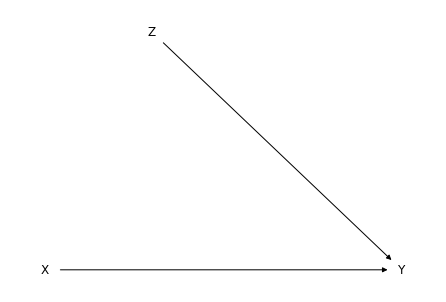

In [38]:
G = nx.DiGraph()
G.graph['dpi'] = 120

nodes = ['X', 'Y', 'Z']
edges = [('Z','Y'), ('X','Y')]
nodes_pos = {'Z':(-.7, 1), 'X':(-1, -1), 'Y':(0, -1)}
nodes_lbl = {'Z':'Z', 'X':'X', 'Y':'Y'}

G.add_nodes_from(nodes)
G.add_edges_from(edges)
nx.draw(G,nodes_pos,node_size=800,node_color='white')
_ = nx.draw_networkx_labels(G,nodes_pos,nodes_lbl)

Let us then define a function randomly assigning a medicine to a patient:

In [39]:
def interventional_medicine():
    return np.random.binomial(1,.5)

And now we setup the loop to collect a set of *interventions*.

In [40]:
def run_interventional_simulation(n_trials=n_trials):
    
    results = {'x': np.zeros(n_trials),
               'z': np.zeros(n_trials),
               'y': np.zeros(n_trials)}
    
    for i in tqdm(range(n_trials)):
        status = SEstatus()
        medicine = interventional_medicine()            
        outcome = recovery(medicine,status)
        
        results['x'][i] = medicine
        results['z'][i] = status
        results['y'][i] = outcome
    
    return results

In [41]:
int_res = run_interventional_simulation()

100%|█████████████████████████████████| 10000/10000 [00:00<00:00, 234131.62it/s]


Let us estimate the effectiveness of a medicine as the probability of leading to survival by computing $P(Y=1 \vert do(X=0))$ and $P(Y=1 \vert do(X=1))$.

In [42]:
n_recovery_medicineA = np.sum(int_res['y'][int_res['x']==0])
n_medicineA = np.sum(int_res['x']==0)

print('Probability of recovery acting on medicine A: {0}'.format(n_recovery_medicineA / n_medicineA))

Probability of recovery acting on medicine A: 0.411611088790679


In [43]:
n_recovery_medicineB = np.sum(int_res['y'][int_res['x']==1])
n_medicineB = np.sum(int_res['x']==1)

print('Probability of recovery acting on medicine B: {0}'.format(n_recovery_medicineB / n_medicineB))

Probability of recovery acting on medicine B: 0.35663082437275984


We have now obtained a better estimation of the effectiveness of the medicines; in particular, we have that medicine A is more effective than medicine B, as we would expect.

## Do-calculus study

Suppose we could not perform (for legal or ethical reasons) experiments. Given our observational causal model, we could still estimate the interventional quantity of interest using *do-calculus*. Knowing that the causal graph is:

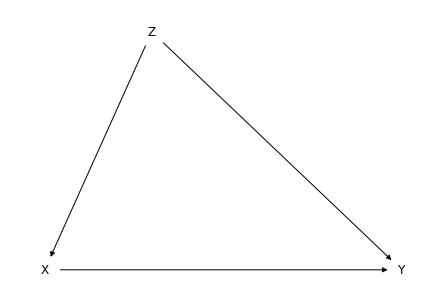

In [44]:
G = nx.DiGraph()
G.graph['dpi'] = 120

nodes = ['X', 'Y', 'Z']
edges = [('Z','X'), ('Z','Y'), ('X','Y')]
nodes_pos = {'Z':(-.7, 1), 'X':(-1, -1), 'Y':(0, -1)}
nodes_lbl = {'Z':'Z', 'X':'X', 'Y':'Y'}

G.add_nodes_from(nodes)
G.add_edges_from(edges)
nx.draw(G,nodes_pos,node_size=800,node_color='white')
_ = nx.draw_networkx_labels(G,nodes_pos,nodes_lbl)

Then *do-calculus* teaches us that we can estimate:
$$
P(Y=1 \vert do(X=x)) = \sum_Z P(Y=1 \vert X,Z)P(Z).
$$
Let us verify this on our simulation. We decompose the formula as:
$$
P(Y=1 \vert do(X=x)) = \sum_Z \frac{P(Y=1,X,Z)}{P(X,Z)}P(Z).
$$

In [45]:
P_z0 = np.sum(obs_res['z']==0) / len(obs_res['z'])
P_z1 = np.sum(obs_res['z']==1) / len(obs_res['z'])

P_y1x0z0 = np.sum(np.logical_and(obs_res['y']==1, np.logical_and(obs_res['x']==0,obs_res['z']==0)))
P_y1x0z1 = np.sum(np.logical_and(obs_res['y']==1, np.logical_and(obs_res['x']==0,obs_res['z']==1)))
P_y1x1z0 = np.sum(np.logical_and(obs_res['y']==1, np.logical_and(obs_res['x']==1,obs_res['z']==0)))
P_y1x1z1 = np.sum(np.logical_and(obs_res['y']==1, np.logical_and(obs_res['x']==1,obs_res['z']==1)))

P_x0z0 = np.sum(np.logical_and(obs_res['x']==0,obs_res['z']==0))
P_x0z1 = np.sum(np.logical_and(obs_res['x']==0,obs_res['z']==1))
P_x1z0 = np.sum(np.logical_and(obs_res['x']==1,obs_res['z']==0))
P_x1z1 = np.sum(np.logical_and(obs_res['x']==1,obs_res['z']==1))

P_y1_givenx0z0 = P_y1x0z0 / P_x0z0
P_y1_givenx0z1 = P_y1x0z1 / P_x0z1
P_y1_givenx1z0 = P_y1x1z0 / P_x1z0
P_y1_givenx1z1 = P_y1x1z1 / P_x1z1

P_y1_dox0 = P_z0 * P_y1_givenx0z0 + P_z1 * P_y1_givenx0z1
P_y1_dox1 = P_z0 * P_y1_givenx1z0 + P_z1 * P_y1_givenx1z1

print('Probability of recovery acting on medicine A: {0}'.format(P_y1_dox0))
print('Probability of recovery acting on medicine B: {0}'.format(P_y1_dox1))

Probability of recovery acting on medicine A: 0.4160700690220282
Probability of recovery acting on medicine B: 0.3477268345864935


We indeed obtain a result very close to the actual experiments without performing any invasive intervention, but using only observational data together with knowledge of the underlying causal model.

## Recap: Observational vs experimental results

Let us try again to explain the discrepancy between observational and interventional results, now in the context of the scenario of evaluating a new medicine.

**What is the meaning of the observational results?**
In the observational scenario we observed $P(Y \vert X=x)$, that is, the probability of a patient to recover by letting her choose the medicine. 

Now it happens that patients with a low socio-economic background tendentially choose medicine A (maybe because it is cheaper), while patients with a high socio-economic background normally opt for a medicine B (maybe because of advertisement). It also happens that the recovery rate of patients with a high socio-economic background is in general higher than that of patients with a low socio-economic background (maybe because of a richer diet). This higher base rate, combined with a predilection for medicine B, makes medicine B look more effective. 

**What is the meaning of the interventional results?**
In the interventional scenario we observed $P(Y \vert do(X=x))$, that is, the probability of a patient to recover by forcing her to assume a randomly-selected medicine.

Through randomization we break the association between low socio-economic background and medicine A, and high socio-economic background and medicine B. This allows us to probe the mechanism of recovery without the bias introduced by the confounder. And in this way we recover the actual effectiveness of the two treatments, leading us to conclude that, independently from external factors, medicine A is *on average* more effective than medicine B.

We have also shown that, if randomization is not possible, we could be able to reconstruct interventional results from observational data given the underlying causal model and relying on do-calculus.

## Recap: Casino vs medicines

It is worth pointing out that, in the scenarios above, while we are always struggling with confounders in an identical model, we are trying to answer different questions:

- In the *greedy casino* scenario we can probably phrase our problem in terms of **fairness** or **law**. However, such a question may be presented in two different forms:
    - Do we care about the proportion of actual customer leaving the building after having won? Then we should look at $P(Y)$ in our model;
    - Do we care that the mechanism (and only one mechanism) in place within the machine generates victories with a certain probability? Then we should look at $P(Y\vert do(X=x))$ in our model.

In the casino case, the state officials are probably concerned not only with the *absolute* causal effect of the lever. State officials should probably be concerned with how the discrepancy with the observational distribution is generated and whether something unlawful is in place to induce it (thus determining if the casino is greedy or ungreedy).
    
- In the *new medicine* scenario we can probably phrase our problem in terms of **effectiveness** or **ethics**: 
    - Having to make a decision for the patient and assuming we have no other knowledge, which medicine is the most likely to lead to survival? Then we should look at $P(Y\vert do(X=x))$.
    
In the medical case, the doctor wants to be certain of the *absolute* causal effect of the medicine. Independently from whether the medicine will be prescribed, whether the patient will choose it, or whether the state will approve it, we want to know if the medicine is effective against a certain disease, and thus more likely to cause a recovery.

# Policymaking for a new medicine

Let us develop further our example about the development of a new medicine.

## Scenario

Let us consider the same scenario we have worked on before. Having shown that medicine A is more effective than medicine B, we may wonder whether this could justify policymaking in favor of a legal adoption of medicine A. To evaluate this point let us run further simulations.

Let us assume that two different teams conducted the observational and the interventional study we performed above. Let us further imagine that they go on enforcing a medical protocol that always provide the medicine with highest effectiveness.

## Policymaking study

Let us start with the observational team. Observing that medicine B seems more effective, they will make every patient use medicine B. Let us compute the recovery rate $P(Y=1\vert \pi_B)$, where $\pi_B$ is the policy that always enforces $do(X=1)$.

In [46]:
def interventional_medicine():
    return 1

In [47]:
int_res = run_interventional_simulation()

100%|█████████████████████████████████| 10000/10000 [00:00<00:00, 321989.84it/s]


In [48]:
print('Probability of recovery for policy A: {0}'.format(np.sum(int_res['y']==1) / len(int_res['y'])))

Probability of recovery for policy A: 0.3581


Let us now move to the interventional team. Based on their estimation, they will instead make every patient assume medicine A. Let us compute the recovery rate that in their case, that is, $P(Y=1\vert \pi_A)$, where $\pi_A$ is the policy that always enforces $do(X=0)$.

In [49]:
def interventional_medicine():
    return 0

In [50]:
int_res = run_interventional_simulation()

100%|█████████████████████████████████| 10000/10000 [00:00<00:00, 324981.13it/s]


In [51]:
print('Probability of recovery for policy B: {0}'.format(np.sum(int_res['y']==1) / len(int_res['y'])))

Probability of recovery for policy B: 0.401


The interventional team achieved, as expected, a higher recovery rate.

Is that the best solution? It actually happens that if we let things go as they were naturally going without interventions we would have a higher recovery rate; let us compute $P(Y=1\vert \pi_\emptyset)$, where $\pi_\emptyset$ is a null-policy that reduces to observation $P(Y=1)$.

In [52]:
obs_res = run_observational_simulation()

100%|█████████████████████████████████| 10000/10000 [00:00<00:00, 229693.98it/s]


In [53]:
print('Probability of recovery for no policy: {0}'.format(np.sum(obs_res['y']==1) / len(obs_res['y'])))

Probability of recovery for no policy: 0.4111


The better result is due to the fact that the patients left to their own devices select a medicine that happens to work better given their own state. However, it is important to explain *happens*: confounders led the patients to make a better choice than any interventional protocol. This, of course, is not always the case: in other scenarios it may well happen that patients left to their own devices make sub-optimal choices, and that an interventional policy would produce better results.

## Recap: Intervening vs policymaking

The result of the above simulations may not be intuitive, so let's try to explain them further.

**What is the meaning of the studies we carried out related to policymaking?** Our studies allowed us to evaluate out system under different conditions:
- *Observational study*: this study evaluated the system when all confounders are in place; no intervention is performed; what we learn is the statistical relation between a medicine ($X$) and an outcome ($Y$). This knowledge is good for prediction in a *natural setting*, but it does not provide information on how our intervening would interact with the confounders.
- *Interventional study*: this study evaluated the system when all the relevant confounders have been disconnected from the treatment; what we learn is the actual causal relation between a medicine ($X$) and an outcome ($Y$). This knowledge is good for understanding how $Y$ is affected by an intervention on $X$, *ceteribus paribus*; however, it does not provide information on how our intervening would interact with the confounders (that is when the *ceteribus paribus* condition does not hold).

**Should we intervene or not?** Performing an intervenional study allowed us to find which medicine is, on average, more effective. This finding however may not immediately justify the adoption of a medicine instead of another (medicine A over medicine B). 

In the real-world, when we deal with actual confounders, we care about how the outcome ($Y$) is affected not only by the causal power of the new medicine ($X$), but also by the causal power derived from interactions between the medicine itself and the confounders ($Z$).

Thus an interventional study can not guarantee that, once we take into account confounding factors, a different interventional policy or a purely observational policy would not produce a higher recovery rate.

## CATE study

Ideally the best policy would be an individualized policy that does not rely simply on the *average treatment effect* (ATE) of the medicine. More refined policies taking into account external factors may achieve better results than a blanket interventional policy ($\pi_A, \pi_B$) or a blind observational no-intervention policy ($\pi_\emptyset$). One first option is relying on the *conditional average treatment effect* (CATE), computed by considering features correlated to an unobserved confounder. This could allow us to tailor more effective policies.

Let us consider the medicine scenario again, where outcomes are confounded by the unobserved *socio-economic status* ($Z$). Let us now assume that we can observe a variable *income* ($W$) which is observable and highly correlated with *socio-economic status*.

We implement our new observable in the following function:

In [54]:
def income(status):
    if status==0:
        return np.random.binomial(1,.1)
    else:
        return np.random.binomial(1,.9)

Simply put, *income()* provides us with the value of socio-economic status with a probability of $0.9$. The model underlying our new interventional model has the following form:

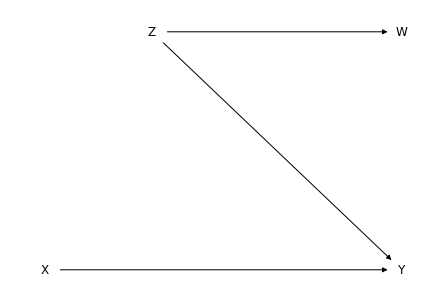

In [55]:
G = nx.DiGraph()
G.graph['dpi'] = 120

nodes = ['X', 'Y', 'Z', 'W']
edges = [('Z','Y'), ('X','Y'), ('Z','W')]
nodes_pos = {'Z':(-.7, 1), 'X':(-1, -1), 'Y':(0, -1), 'W':(0, 1)}
nodes_lbl = {'Z':'Z', 'X':'X', 'Y':'Y', 'W':'W'}

G.add_nodes_from(nodes)
G.add_edges_from(edges)
nx.draw(G,nodes_pos,node_size=800,node_color='white')
_ = nx.draw_networkx_labels(G,nodes_pos,nodes_lbl)

Let us now run interventional simulations and estimate some *CATE* quantities.

In [56]:
def run_CATE_simulation(n_trials=n_trials):
    
    results = {'x': np.zeros(n_trials),
               'z': np.zeros(n_trials),
               'y': np.zeros(n_trials),
               'w': np.zeros(n_trials)}
    
    for i in tqdm(range(n_trials)):
        status = SEstatus()
        proxy = income(status)
        medicine = interventional_medicine()            
        outcome = recovery(medicine,status)
        
        results['x'][i] = medicine
        results['z'][i] = status
        results['y'][i] = outcome
        results['w'][i] = proxy
    
    return results

We start by considering the intervention $do(X=0)$.

In [57]:
def interventional_medicine():
    return 0

We collect our samples.

In [58]:
cate_res = run_CATE_simulation()

100%|█████████████████████████████████| 10000/10000 [00:00<00:00, 218756.40it/s]


As before we can simply estimate the probability of recovery $P(Y\vert do(X=0))$:

In [59]:
P_doX0 = np.sum(cate_res['y']==1) / len(cate_res['y'])
print('Probability of recovery acting on medicine A: {0}'.format(P_doX0))

Probability of recovery acting on medicine A: 0.4069


However, we are now interested in estimating how this probability varies conditioned on the income variable, which acts as a proxy for socio-economic status. We estimate first $P(Y\vert do(X=0),W=0)$:

In [60]:
P_doX0_givenW0 = np.sum(np.logical_and(cate_res['y']==1,cate_res['w']==0)) / np.sum(cate_res['w']==0)
print('Probability of recovery acting on medicine A given income 0: {0}'.format(P_doX0_givenW0))

Probability of recovery acting on medicine A given income 0: 0.41284403669724773


And then $P(Y\vert do(X=0),W=1)$:

In [61]:
P_doX0_givenW1 = np.sum(np.logical_and(cate_res['y']==1,cate_res['w']==1)) / np.sum(cate_res['w']==1)
print('Probability of recovery acting on medicine A given income 1: {0}'.format(P_doX0_givenW1))

Probability of recovery acting on medicine A given income 1: 0.4009225832330525


Notice that these values are close to the ground truth of $0.4$ that we encoded both for the high and low socio-economic status. Deviations are partly explained by our noisy proxy which agrees with the unobserved confounders only with probability $0.9$.

Let us then move to considering the intervention $do(X=1)$:

In [62]:
def interventional_medicine():
    return 1

We collect samples for this interventional setting as well:

In [63]:
cate_res = run_CATE_simulation()

100%|█████████████████████████████████| 10000/10000 [00:00<00:00, 223064.49it/s]


We first compute the generic recovery probability $P(Y\vert do(X=1))$:

In [64]:
P_doX1 = np.sum(cate_res['y']==1) / len(cate_res['y'])
print('Probability of recovery acting on medicine B: {0}'.format(P_doX1))

Probability of recovery acting on medicine B: 0.3507


Then we evaluate conditional quantities $P(Y\vert do(X=1),W=0)$:

In [65]:
P_doX1_givenW0 = np.sum(np.logical_and(cate_res['y']==1,cate_res['w']==0)) / np.sum(cate_res['w']==0)
print('Probability of recovery acting on medicine B given income 0: {0}'.format(P_doX1_givenW0))

Probability of recovery acting on medicine B given income 0: 0.27400793650793653


And $P(Y\vert do(X=1),W=1)$:

In [66]:
P_doX1_givenW1 = np.sum(np.logical_and(cate_res['y']==1,cate_res['w']==1)) / np.sum(cate_res['w']==1)
print('Probability of recovery acting on medicine B given income 1: {0}'.format(P_doX1_givenW1))

Probability of recovery acting on medicine B given income 1: 0.42862903225806454


Again these values come close to the hard-coded values in our simulation.

Without information about the conditioning variable, all we can do is computing the *average treatment effect* (ATE), that is $P(Y\vert do(X=1)) - P(Y\vert do(X=0))$:

In [67]:
ate = P_doX1 - P_doX0
print(ate)

-0.05619999999999997


This is the difference (of about $5\%$) that led us to conclude in the previous interventional study that medicine A has a stronger causal effect on recovery. It is also the quantity that led us to suggest a blanket policy $\pi_A$ for the adoption of medicine A that turned out to be suboptimal.

Now, however, we can compute the *conditional average treatment effect* (CATE) taking advantage of our knowledge of income. This allow us to compute $P(Y\vert do(X=1),W=0) - P(Y\vert do(X=0),W=0)$:

In [68]:
cate0 = P_doX1_givenW0 - P_doX0_givenW0
print(cate0)

-0.1388361001893112


and $P(Y\vert do(X=1),W=1) - P(Y\vert do(X=0),W=1)$:

In [69]:
cate1 = P_doX1_givenW1 - P_doX0_givenW1
print(cate1)

0.027706449025012014


This reveals that for a low income (strongly correlated with a low socio-economic status) medicine A is more effective, while for a high income (strongly correlated with a high socio-economic status) medicine B is actually slightly more effective.

This knowledge allows us to define a better policy $\pi_{income}$ in which we exploit knowledge of income (and, indirectly, of the true confounder) to select which medicine to offer to a patient.

In [70]:
def CATE_medicine(income):
    if income==0: 
        return 0
    else:
        return 1

Let us now set a simulation using this policy $\pi_{income}$:

In [71]:
def run_CATE_simulation(n_trials=n_trials):
    
    results = {'x': np.zeros(n_trials),
               'z': np.zeros(n_trials),
               'y': np.zeros(n_trials),
               'w': np.zeros(n_trials)}
    
    for i in tqdm(range(n_trials)):
        status = SEstatus()
        proxy = income(status)
        medicine = CATE_medicine(proxy)            
        outcome = recovery(medicine,status)
        
        results['x'][i] = medicine
        results['z'][i] = status
        results['y'][i] = outcome
        results['w'][i] = proxy
    
    return results

We collect the samples:

In [72]:
cate_res = run_CATE_simulation()

100%|█████████████████████████████████| 10000/10000 [00:00<00:00, 222722.18it/s]


And evaluate our recovery probability $P(Y\vert \pi_{income})$:

In [73]:
print('Probability of recovery for policy CATE: {0}'.format(np.sum(cate_res['y']==1) / len(cate_res['y'])))

Probability of recovery for policy CATE: 0.4095


The recovery rate is now higher than the trivial blanket interventional policies ($\pi_A,\pi_B$) or the observational policy ($\pi_\emptyset$).

Of course, this result depends on how well our proxy variable (income) follows the underlying and unobserved confounder (socio-economic status). In *CATE sensitivity example* in the Appendix it is shown that the quality of the estimation of the CATE effect depends on such a relationship. Often proxies may have complicated dynamics, or simply there may be no way of observing them.

## Counterfactual study

An even finer-grained analysis may be offered by a counterfactual evaluation in which we can assess the *individual treatment effect* (ITE) for each subject. Estimating an ITE requires evaluating *counterfactual quantities*, and specifically consider the probability of recovery under the actual choice $P(Y=1 \vert X=x)$ and the probability of recovery in the counterfactual scenario in which a patient would have been given a different medicine $P_{X=x}(Y=1 \vert X=\bar{x})$. (This quantity is also used in [Bareinboim2015] to deal with the greedy casino.)

To work with counterfactual, we work with our basic causal graph:

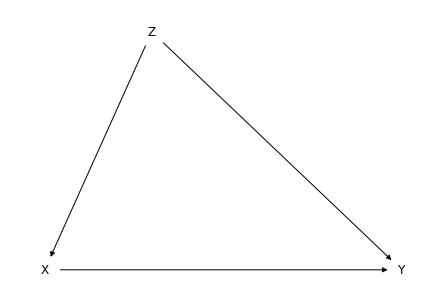

In [74]:
G = nx.DiGraph()
G.graph['dpi'] = 120

nodes = ['X', 'Y', 'Z']
edges = [('Z','X'), ('Z','Y'), ('X','Y')]
nodes_pos = {'Z':(-.7, 1), 'X':(-1, -1), 'Y':(0, -1)}
nodes_lbl = {'Z':'Z', 'X':'X', 'Y':'Y'}

G.add_nodes_from(nodes)
G.add_edges_from(edges)
nx.draw(G,nodes_pos,node_size=800,node_color='white')
_ = nx.draw_networkx_labels(G,nodes_pos,nodes_lbl)

Estimating counterfactual quantities is usually practically impossibile. Here, we take advantage of our computation approach, and we set up a counterfactual simulation.

The idea is that, given an individual (or a patient or a unit), we want to compute the effectiveness of the medicine for *this particular individual* by using counterfactual quantities. Our estimation is not above a population (ATE), but for a single individual (ITE).

In [75]:
def run_CF_simulation(n_trials=n_trials):
    
    results = {'x': np.zeros(n_trials),
               'z': np.zeros(n_trials),
               'y': np.zeros(n_trials),
               'cfy': np.zeros(n_trials),}
    
    status = SEstatus()
    for i in tqdm(range(n_trials)):
        
        medicine = interventional_medicine()            
        outcome = recovery(medicine,status)
        
        cf_medicine = np.logical_not(medicine)
        cf_outcome = recovery(cf_medicine,status)
        
        results['x'][i] = medicine
        results['z'][i] = status
        results['y'][i] = outcome
        results['cfy'][i] = cf_outcome
    
    return results

Notice how this simulation is different from the previous ones:
- We do not iterate over many individuals (each one with her own socio-economic status) in order to compute the average treatment effect, but we iterate on the same individual (with a unique socio-economic status) in  order to compute the individual treatment effect;
- We run a factual simulation first which produces $X,Y,Z$; then, we artificially run a counterfactual simulation in which we keep $Z$ to its value (this enforces the *ceteribus paribus* requirement of counterfactuals), we force the medicine $X$ to assume a different value, and then we recompute $Y$. 

Let us run the simulation. For simplicity, let us assume the factual intervention to be always $do(X=0)$:

In [76]:
def interventional_medicine():
    return 0

In [77]:
cf_res = run_CF_simulation()

100%|█████████████████████████████████| 10000/10000 [00:00<00:00, 230356.27it/s]


Notice we run a single simulation, corresponding to a single individual. Now we can compute the individual treatment effect as a difference between 

We can now compute the ITE for the individual as $$P_{X=0}(Y=1 \vert do(X=1)) - P(Y=1 \vert do(X=0))$$
where the first quantity is the counterfactual result of providing medicine B, while the second quantity is the result of providing the first medicine.

In [78]:
np.sum((cf_res['cfy']-cf_res['y'])) / len(cf_res['y'])

0.062

In this case, we found out that for the specific individual medicine B is more effective. However, if we consider a few more individuals, we will stumble into subjects for whom medicine A is more effective:

In [79]:
for i in range(10):
    cf_res = run_CF_simulation()
    print('ITE for individual {0}: {1}'.format(i,np.sum((cf_res['cfy']-cf_res['y'])) / len(cf_res['y'])))

100%|█████████████████████████████████| 10000/10000 [00:00<00:00, 232714.36it/s]

ITE for individual 0: 0.051



100%|█████████████████████████████████| 10000/10000 [00:00<00:00, 234515.18it/s]


ITE for individual 1: 0.0429


100%|█████████████████████████████████| 10000/10000 [00:00<00:00, 234846.08it/s]


ITE for individual 2: 0.0442


100%|█████████████████████████████████| 10000/10000 [00:00<00:00, 237710.35it/s]


ITE for individual 3: 0.049


100%|█████████████████████████████████| 10000/10000 [00:00<00:00, 235144.95it/s]


ITE for individual 4: 0.0565


100%|█████████████████████████████████| 10000/10000 [00:00<00:00, 235787.39it/s]


ITE for individual 5: -0.1395


100%|█████████████████████████████████| 10000/10000 [00:00<00:00, 233742.79it/s]


ITE for individual 6: 0.0555


100%|█████████████████████████████████| 10000/10000 [00:00<00:00, 231149.71it/s]


ITE for individual 7: -0.15


100%|█████████████████████████████████| 10000/10000 [00:00<00:00, 232949.59it/s]


ITE for individual 8: -0.1474


100%|█████████████████████████████████| 10000/10000 [00:00<00:00, 236809.79it/s]

ITE for individual 9: 0.0462


Counterfactual analysis allows us to consider different quantities (*effect of the treatment of treated*, *probability of necessity and sufficiency*) which provide us with deeper insights into our system.

## Recap: Interventional vs conditional interventional vs counterfactual

Our simulations showed that in order to define a good policy we may want to carry out several analysis of our system in order to figure out the effect and the impact of our actions and the confounders. 

**What is the meaning of our studies in relation to policymaking?** Different studies allowed us to better probe the contribution of an unobserved confounder:
- *Interventional studies* allowed us only to assess the average treatment effect (ATE) of a medicine on the outcome $P(Y\vert do(X=x))$; this study objectively assessed the effectiveness of the medicines, but it did not take into consideration how confounders may affect the real-world distribution of patients and the interaction between the confounder and our action;
- *Conditional interventional studies* identified a proxy variable for the unobserved confounder underlying our model. This allowed us to assess the conditional average treatment effect (CATE) of a medicine on the outcome $P(Y\vert do(X=x),W)$; in particular, we were able to evaluate how the effectiveness of our actions would change at different levels of the unobserved confounder (as revealed by the proxy variable $W$);
- *Counterfactual studies* took full advantage of the structural causal model framework to evaluate interventions in alternative counterfactual worlds. This allowed us to assess the individual treatment effect (ITE) of a medicine on the outcome $P(Y\vert do(X=x))$ for a specific individual; this means that we could devise an optimal policy (with respect to the causal model we have defined) for each individual. Unfortunately, counterfactual quantities are hard to estimate.

# Simpson's paradox: effectiveness of a new medicine

Let's consider again our original observational and interventional studies that we performed to evaluate the effectiveness of a new medicine. The discrepancy that we have noticed between the observational result (medicine B is more effective than medicine A) and interventional result (medicine A is more effective than medicine B) may be seen as a case of *Simpson's paradox*. 

Simpson's paradox is a classical example in which confounder may lead to apparently paradoxical results. This paradox may be explained away in terms of modelling. In the previous discussion we have qualified our results always in relation to an assumed graphical causal model underlying our data. A wrong choice in this assumption may sometimes explain apparent paradoxes.

For example, in the observational study, when we believed we were directly assessing the causal effect of  a medicine on recovery $P(Y\vert X)$, we were implicitly and mistakenly assuming the following causal model:

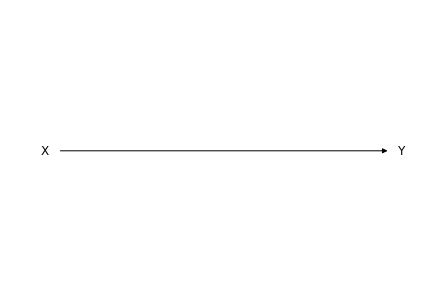

In [80]:
G = nx.DiGraph()
G.graph['dpi'] = 120

nodes = ['X', 'Y',]
edges = [('X','Y')]
nodes_pos = {'X':(-1, -1), 'Y':(0, -1)}
nodes_lbl = {'X':'X', 'Y':'Y'}

G.add_nodes_from(nodes)
G.add_edges_from(edges)
nx.draw(G,nodes_pos,node_size=800,node_color='white')
_ = nx.draw_networkx_labels(G,nodes_pos,nodes_lbl)

When we performed our interventional study, we correctly identified the underlying model as:

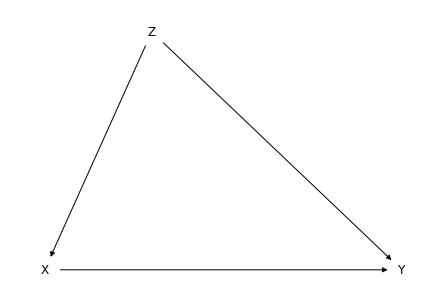

In [81]:
G = nx.DiGraph()
G.graph['dpi'] = 120

nodes = ['X', 'Y', 'Z']
edges = [('Z','X'), ('Z','Y'), ('X','Y')]
nodes_pos = {'Z':(-.7, 1), 'X':(-1, -1), 'Y':(0, -1)}
nodes_lbl = {'Z':'Z', 'X':'X', 'Y':'Y'}

G.add_nodes_from(nodes)
G.add_edges_from(edges)
nx.draw(G,nodes_pos,node_size=800,node_color='white')
_ = nx.draw_networkx_labels(G,nodes_pos,nodes_lbl)

and we correctly estimated $P(Y\vert do(X))$ by removing the confounder through an intervention or via do-calculus, thus ending up working on:

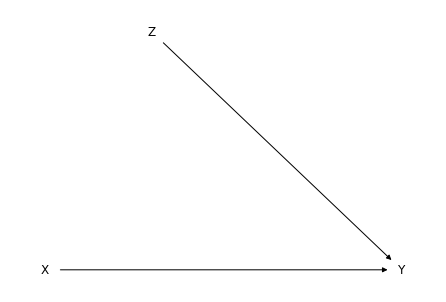

In [82]:
G = nx.DiGraph()
G.graph['dpi'] = 120

nodes = ['X', 'Y', 'Z']
edges = [('Z','Y'), ('X','Y')]
nodes_pos = {'Z':(-.7, 1), 'X':(-1, -1), 'Y':(0, -1)}
nodes_lbl = {'Z':'Z', 'X':'X', 'Y':'Y'}

G.add_nodes_from(nodes)
G.add_edges_from(edges)
nx.draw(G,nodes_pos,node_size=800,node_color='white')
_ = nx.draw_networkx_labels(G,nodes_pos,nodes_lbl)

The discrepancy in the effectiveness of the medicine may thus be ascribed to a *misspecified model*: the observational causal estimation is correct with respect to the no-confounder model, but wrong with respect to the causal model with confounder; the interventional estimation is correct with respect to the causal model with confounder.

Is our interventional result the final word on the effect of the medicine on the survival? Of course not: it depends on the model we consider.

## Scenario

Let us consider a more elaborate model in which we have two confounders: a socio-economic status ($Z_{se}$) and a genetic factor ($Z_{g}$). The true underlying graph of our new model is:

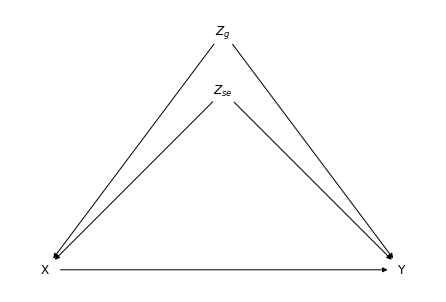

In [83]:
G = nx.DiGraph()
G.graph['dpi'] = 120

nodes = ['X', 'Y', 'Zse', 'Zg']
edges = [('Zse','X'), ('Zse','Y'), ('X','Y'),('Zg','X'), ('Zg','Y')]
nodes_pos = {'Zse':(-.5, .5),'Zg':(-.5, 1), 'X':(-1, -1), 'Y':(0, -1)}
nodes_lbl = {'Zse':'$Z_{se}$','Zg':'$Z_{g}$', 'X':'X', 'Y':'Y'}

G.add_nodes_from(nodes)
G.add_edges_from(edges)
nx.draw(G,nodes_pos,node_size=800,node_color='white')
_ = nx.draw_networkx_labels(G,nodes_pos,nodes_lbl)

## Implementation

Let us construct the computational model for this new scenario.

In [84]:
def GStatus():
    return np.random.binomial(1,p=.5)

def SEStatus():
    return np.random.binomial(1,p=.5)

def recovery(medicine,SEstatus,Gstatus):
    if Gstatus==0:
        if SEstatus==0:
            if medicine==0:
                return np.random.binomial(1,.2)
            else:
                return np.random.binomial(1,.05)
        else:
            if medicine==0:
                return np.random.binomial(1,.4)
            else:
                return np.random.binomial(1,.45)
    else:
        if SEstatus==0:
            if medicine==0:
                return np.random.binomial(1,.6)
            else:
                return np.random.binomial(1,.45)
        else:
            if medicine==0:
                return np.random.binomial(1,.4)
            else:
                return np.random.binomial(1,.45)

Notice how the recovery rates are now different, as they are affected by two confounders.

## Observational study

We now run a standard observational study.

In [85]:
def observational_medicine(SEstatus,Gstatus):
    if Gstatus==0:
        if SEstatus==0:
            return np.random.binomial(1,.1)
        else:
            return np.random.binomial(1,.95)
    else:
        if SEstatus==0:
            return np.random.binomial(1,.1)
        else:
            return np.random.binomial(1,.85)

In [86]:
def run_observational_simulation(n_trials=n_trials):
    
    results = {'x': np.zeros(n_trials),
               'z_se': np.zeros(n_trials),
               'z_g': np.zeros(n_trials),
               'y': np.zeros(n_trials)}
    
    for i in tqdm(range(n_trials)):
        SEstatus = SEStatus()
        Gstatus = GStatus()
        medicine = observational_medicine(SEstatus,Gstatus)            
        outcome = recovery(medicine,SEstatus,Gstatus)
        
        results['x'][i] = medicine
        results['z_se'][i] = SEstatus
        results['z_g'][i] = Gstatus
        results['y'][i] = outcome
    
    return results

In [87]:
obs_res = run_observational_simulation()

100%|█████████████████████████████████| 10000/10000 [00:00<00:00, 173415.09it/s]


We can then estimate the probabilities $P(Y=1 \vert X=0)$ and $P(Y=1 \vert X=1)$.

In [88]:
n_recovery_medicineA = np.sum(obs_res['y'][obs_res['x']==0])
n_medicineA = np.sum(obs_res['x']==0)

print('Probability of recovery given medicine A: {0}'.format(n_recovery_medicineA / n_medicineA))

Probability of recovery given medicine A: 0.39102173471460494


In [89]:
n_recovery_medicineB = np.sum(obs_res['y'][obs_res['x']==1])
n_medicineB = np.sum(obs_res['x']==1)

print('Probability of recovery given medicine B: {0}'.format(n_recovery_medicineB / n_medicineB))

Probability of recovery given medicine B: 0.42485719913334646


Apparently medicine B is more effective than A. Giving a causal meaning to this result would be equivalent to assuming that we are working with the following model:

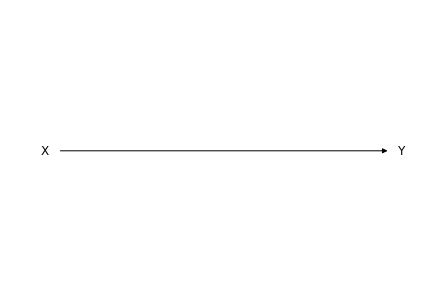

In [90]:
G = nx.DiGraph()
G.graph['dpi'] = 120

nodes = ['X', 'Y',]
edges = [('X','Y')]
nodes_pos = {'X':(-1, -1), 'Y':(0, -1)}
nodes_lbl = {'X':'X', 'Y':'Y'}

G.add_nodes_from(nodes)
G.add_edges_from(edges)
nx.draw(G,nodes_pos,node_size=800,node_color='white')
_ = nx.draw_networkx_labels(G,nodes_pos,nodes_lbl)

However, we know this model is wrong, so we move on to an interventional study.

## Interventional study

Let us define an intervention protocol.

In [91]:
def interventional_medicine():
    return np.random.binomial(1,.5)

In [92]:
def run_interventional_simulation(n_trials=n_trials):
    
    results = {'x': np.zeros(n_trials),
               'z_se': np.zeros(n_trials),
               'z_g': np.zeros(n_trials),
               'y': np.zeros(n_trials)}
    
    for i in tqdm(range(n_trials)):
        SEstatus = SEStatus()
        Gstatus = GStatus()
        medicine = interventional_medicine()            
        outcome = recovery(medicine,SEstatus,Gstatus)
        
        results['x'][i] = medicine
        results['z_se'][i] = SEstatus
        results['z_g'][i] = Gstatus
        results['y'][i] = outcome
    
    return results

In [93]:
int_res = run_interventional_simulation()

100%|█████████████████████████████████| 10000/10000 [00:00<00:00, 170878.74it/s]


This allows us to compute $P(Y=1 \vert do(X=0))$ and $P(Y=1 \vert do(X=1))$.

In [94]:
n_recovery_medicineA = np.sum(int_res['y'][int_res['x']==0])
n_medicineA = np.sum(int_res['x']==0)

print('Probability of recovery acting on medicine A: {0}'.format(n_recovery_medicineA / n_medicineA))

Probability of recovery acting on medicine A: 0.39489154672613014


In [95]:
n_recovery_medicineB = np.sum(int_res['y'][int_res['x']==1])
n_medicineB = np.sum(int_res['x']==1)

print('Probability of recovery acting on medicine B: {0}'.format(n_recovery_medicineB / n_medicineB))

Probability of recovery acting on medicine B: 0.3447799486875863


These results correctly estimate that medicine A is more effective than medicine B, as we would expect. Indeed, performing an intervention leads us to work with the following post-interventional model:

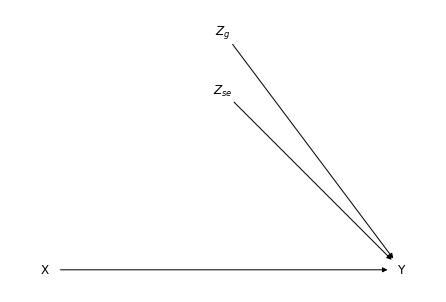

In [96]:
G = nx.DiGraph()
G.graph['dpi'] = 120

nodes = ['X', 'Y', 'Zse', 'Zg']
edges = [('Zse','Y'), ('X','Y'), ('Zg','Y')]
nodes_pos = {'Zse':(-.5, .5),'Zg':(-.5, 1), 'X':(-1, -1), 'Y':(0, -1)}
nodes_lbl = {'Zse':'$Z_{se}$','Zg':'$Z_{g}$', 'X':'X', 'Y':'Y'}

G.add_nodes_from(nodes)
G.add_edges_from(edges)
nx.draw(G,nodes_pos,node_size=800,node_color='white')
_ = nx.draw_networkx_labels(G,nodes_pos,nodes_lbl)

which correctly cuts out the influence of all the confounders and let us estimate the correct causal effect of $X$ on $Y$.

## Do-calculus study

Let us suppose to be in a situation in which interventions are not possible. We may want to try to estimate causal quantities from the observational variables.

We may be first induced to work with the model considering only the socio-economic status because it has already proven quite successful. That is, we may assume that only socio-economic factors are relevant confounders. This is equivalent to working with the following graph:

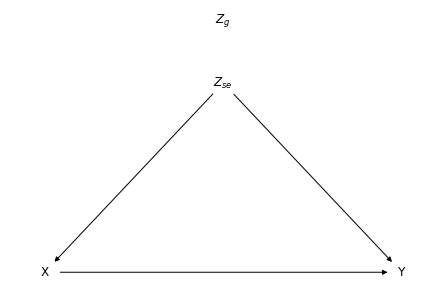

In [97]:
G = nx.DiGraph()
G.graph['dpi'] = 120

nodes = ['X', 'Y', 'Zse', 'Zg']
edges = [('Zse','X'), ('Zse','Y'), ('X','Y')]
nodes_pos = {'Zse':(-.5, .5),'Zg':(-.5, 1), 'X':(-1, -1), 'Y':(0, -1)}
nodes_lbl = {'Zse':'$Z_{se}$','Zg':'$Z_{g}$', 'X':'X', 'Y':'Y'}

G.add_nodes_from(nodes)
G.add_edges_from(edges)
nx.draw(G,nodes_pos,node_size=800,node_color='white')
_ = nx.draw_networkx_labels(G,nodes_pos,nodes_lbl)

In such a graph, *do-calculus* instructs to estimate:
$$
P(Y=1 \vert do(X=x)) = \sum_{Z_{se}} P(Y=1 \vert X,{Z_{se}})P({Z_{se}}).
$$

In [98]:
P_z0 = np.sum(obs_res['z_se']==0) / len(obs_res['z_se'])
P_z1 = np.sum(obs_res['z_se']==1) / len(obs_res['z_se'])

P_y1x0z0 = np.sum(np.logical_and(obs_res['y']==1, np.logical_and(obs_res['x']==0,obs_res['z_se']==0)))
P_y1x0z1 = np.sum(np.logical_and(obs_res['y']==1, np.logical_and(obs_res['x']==0,obs_res['z_se']==1)))
P_y1x1z0 = np.sum(np.logical_and(obs_res['y']==1, np.logical_and(obs_res['x']==1,obs_res['z_se']==0)))
P_y1x1z1 = np.sum(np.logical_and(obs_res['y']==1, np.logical_and(obs_res['x']==1,obs_res['z_se']==1)))

P_x0z0 = np.sum(np.logical_and(obs_res['x']==0,obs_res['z_se']==0))
P_x0z1 = np.sum(np.logical_and(obs_res['x']==0,obs_res['z_se']==1))
P_x1z0 = np.sum(np.logical_and(obs_res['x']==1,obs_res['z_se']==0))
P_x1z1 = np.sum(np.logical_and(obs_res['x']==1,obs_res['z_se']==1))

P_y1_givenx0z0 = P_y1x0z0 / P_x0z0
P_y1_givenx0z1 = P_y1x0z1 / P_x0z1
P_y1_givenx1z0 = P_y1x1z0 / P_x1z0
P_y1_givenx1z1 = P_y1x1z1 / P_x1z1

P_y1_dox0 = P_z0 * P_y1_givenx0z0 + P_z1 * P_y1_givenx0z1
P_y1_dox1 = P_z0 * P_y1_givenx1z0 + P_z1 * P_y1_givenx1z1

print('Probability of recovery acting on medicine A: {0}'.format(P_y1_dox0))
print('Probability of recovery acting on medicine B: {0}'.format(P_y1_dox1))

Probability of recovery acting on medicine A: 0.39487038390851537
Probability of recovery acting on medicine B: 0.3629170674423526


The result shows that medicine A is more effective than medicine B, but the estimand is less close to the target than before.

Someone may then suggest to us that the only confounder we need to account for are actually genetic factors. Socio-economic factors are not causally relevant, and we should not control for them. We may heed to this advice, and come up with the alternative causal graph:

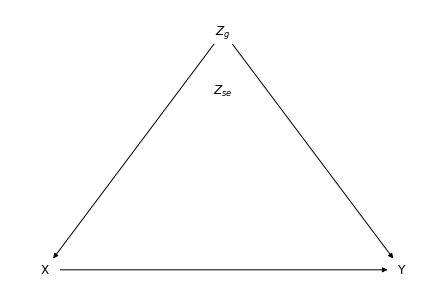

In [99]:
G = nx.DiGraph()
G.graph['dpi'] = 120

nodes = ['X', 'Y', 'Zse', 'Zg']
edges = [('X','Y'),('Zg','X'), ('Zg','Y')]
nodes_pos = {'Zse':(-.5, .5),'Zg':(-.5, 1), 'X':(-1, -1), 'Y':(0, -1)}
nodes_lbl = {'Zse':'$Z_{se}$','Zg':'$Z_{g}$', 'X':'X', 'Y':'Y'}

G.add_nodes_from(nodes)
G.add_edges_from(edges)
nx.draw(G,nodes_pos,node_size=800,node_color='white')
_ = nx.draw_networkx_labels(G,nodes_pos,nodes_lbl)

In such a graph, *do-calculus* tells us that we can estimate:
$$
P(Y=1 \vert do(X=x)) = \sum_{Z_{g}} P(Y=1 \vert X,{Z_{g}})P({Z_{g}}).
$$

In [100]:
P_z0 = np.sum(obs_res['z_g']==0) / len(obs_res['z_g'])
P_z1 = np.sum(obs_res['z_g']==1) / len(obs_res['z_g'])

P_y1x0z0 = np.sum(np.logical_and(obs_res['y']==1, np.logical_and(obs_res['x']==0,obs_res['z_g']==0)))
P_y1x0z1 = np.sum(np.logical_and(obs_res['y']==1, np.logical_and(obs_res['x']==0,obs_res['z_g']==1)))
P_y1x1z0 = np.sum(np.logical_and(obs_res['y']==1, np.logical_and(obs_res['x']==1,obs_res['z_g']==0)))
P_y1x1z1 = np.sum(np.logical_and(obs_res['y']==1, np.logical_and(obs_res['x']==1,obs_res['z_g']==1)))

P_x0z0 = np.sum(np.logical_and(obs_res['x']==0,obs_res['z_g']==0))
P_x0z1 = np.sum(np.logical_and(obs_res['x']==0,obs_res['z_g']==1))
P_x1z0 = np.sum(np.logical_and(obs_res['x']==1,obs_res['z_g']==0))
P_x1z1 = np.sum(np.logical_and(obs_res['x']==1,obs_res['z_g']==1))

P_y1_givenx0z0 = P_y1x0z0 / P_x0z0
P_y1_givenx0z1 = P_y1x0z1 / P_x0z1
P_y1_givenx1z0 = P_y1x1z0 / P_x1z0
P_y1_givenx1z1 = P_y1x1z1 / P_x1z1

P_y1_dox0 = P_z0 * P_y1_givenx0z0 + P_z1 * P_y1_givenx0z1
P_y1_dox1 = P_z0 * P_y1_givenx1z0 + P_z1 * P_y1_givenx1z1

print('Probability of recovery acting on medicine A: {0}'.format(P_y1_dox0))
print('Probability of recovery acting on medicine B: {0}'.format(P_y1_dox1))

Probability of recovery acting on medicine A: 0.38348681762333375
Probability of recovery acting on medicine B: 0.425662020392382


Annoyingly, we observe a reversal of effectiveness: controlling for genetic factors makes medicine B looks more effective than medicine A.

After further study, we come to develop the right causal graph:

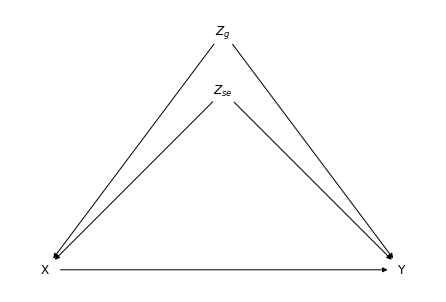

In [101]:
G = nx.DiGraph()
G.graph['dpi'] = 120

nodes = ['X', 'Y', 'Zse', 'Zg']
edges = [('Zse','X'), ('Zse','Y'), ('X','Y'),('Zg','X'), ('Zg','Y')]
nodes_pos = {'Zse':(-.5, .5),'Zg':(-.5, 1), 'X':(-1, -1), 'Y':(0, -1)}
nodes_lbl = {'Zse':'$Z_{se}$','Zg':'$Z_{g}$', 'X':'X', 'Y':'Y'}

G.add_nodes_from(nodes)
G.add_edges_from(edges)
nx.draw(G,nodes_pos,node_size=800,node_color='white')
_ = nx.draw_networkx_labels(G,nodes_pos,nodes_lbl)

Now *do-calculus* states that:
$$
P(Y=1 \vert do(X=x)) = \sum_{Z_{se},Z_{g}} P(Y=1 \vert X,Z_{se},{Z_{g}})P(Z_{se},{Z_{g}}).
$$

In [102]:
P_s0g0 = np.sum(np.logical_and(obs_res['z_se']==0,obs_res['z_g']==0)) / len(obs_res['z_se'])
P_s0g1 = np.sum(np.logical_and(obs_res['z_se']==0,obs_res['z_g']==1)) / len(obs_res['z_se'])
P_s1g0 = np.sum(np.logical_and(obs_res['z_se']==1,obs_res['z_g']==0)) / len(obs_res['z_se'])
P_s1g1 = np.sum(np.logical_and(obs_res['z_se']==1,obs_res['z_g']==1)) / len(obs_res['z_se'])

P_y1x0s0g0 = np.sum(np.logical_and(obs_res['y']==1, np.logical_and(obs_res['x']==0, np.logical_and(obs_res['z_se']==0,obs_res['z_g']==0))))
P_y1x0s0g1 = np.sum(np.logical_and(obs_res['y']==1, np.logical_and(obs_res['x']==0, np.logical_and(obs_res['z_se']==0,obs_res['z_g']==1))))
P_y1x0s1g0 = np.sum(np.logical_and(obs_res['y']==1, np.logical_and(obs_res['x']==0, np.logical_and(obs_res['z_se']==1,obs_res['z_g']==0))))
P_y1x0s1g1 = np.sum(np.logical_and(obs_res['y']==1, np.logical_and(obs_res['x']==0, np.logical_and(obs_res['z_se']==1,obs_res['z_g']==1))))
P_y1x1s0g0 = np.sum(np.logical_and(obs_res['y']==1, np.logical_and(obs_res['x']==1, np.logical_and(obs_res['z_se']==0,obs_res['z_g']==0))))
P_y1x1s0g1 = np.sum(np.logical_and(obs_res['y']==1, np.logical_and(obs_res['x']==1, np.logical_and(obs_res['z_se']==0,obs_res['z_g']==1))))
P_y1x1s1g0 = np.sum(np.logical_and(obs_res['y']==1, np.logical_and(obs_res['x']==1, np.logical_and(obs_res['z_se']==1,obs_res['z_g']==0))))
P_y1x1s1g1 = np.sum(np.logical_and(obs_res['y']==1, np.logical_and(obs_res['x']==1, np.logical_and(obs_res['z_se']==1,obs_res['z_g']==1))))

P_x0s0g0 = np.sum(np.logical_and(obs_res['x']==0, np.logical_and(obs_res['z_se']==0,obs_res['z_g']==0)))
P_x0s0g1 = np.sum(np.logical_and(obs_res['x']==0, np.logical_and(obs_res['z_se']==0,obs_res['z_g']==1)))
P_x0s1g0 = np.sum(np.logical_and(obs_res['x']==0, np.logical_and(obs_res['z_se']==1,obs_res['z_g']==0)))
P_x0s1g1 = np.sum(np.logical_and(obs_res['x']==0, np.logical_and(obs_res['z_se']==1,obs_res['z_g']==1)))
P_x1s0g0 = np.sum(np.logical_and(obs_res['x']==1, np.logical_and(obs_res['z_se']==0,obs_res['z_g']==0)))
P_x1s0g1 = np.sum(np.logical_and(obs_res['x']==1, np.logical_and(obs_res['z_se']==0,obs_res['z_g']==1)))
P_x1s1g0 = np.sum(np.logical_and(obs_res['x']==1, np.logical_and(obs_res['z_se']==1,obs_res['z_g']==0)))
P_x1s1g1 = np.sum(np.logical_and(obs_res['x']==1, np.logical_and(obs_res['z_se']==1,obs_res['z_g']==1)))

P_y1_givenx0s0g0 = P_y1x0s0g0 / P_x0s0g0
P_y1_givenx0s0g1 = P_y1x0s0g1 / P_x0s0g1
P_y1_givenx0s1g0 = P_y1x0s1g0 / P_x0s1g0
P_y1_givenx0s1g1 = P_y1x0s1g1 / P_x0s1g1
P_y1_givenx1s0g0 = P_y1x1s0g0 / P_x1s0g0
P_y1_givenx1s0g1 = P_y1x1s0g1 / P_x1s0g1
P_y1_givenx1s1g0 = P_y1x1s1g0 / P_x1s1g0
P_y1_givenx1s1g1 = P_y1x1s1g1 / P_x1s1g1

P_y1_dox0 = P_s0g0 * P_y1_givenx0s0g0 + P_s0g1 * P_y1_givenx0s0g1 + P_s1g0 * P_y1_givenx0s1g0 + P_s1g1 * P_y1_givenx0s1g1
P_y1_dox1 = P_s0g0 * P_y1_givenx1s0g0 + P_s0g1 * P_y1_givenx1s0g1 + P_s1g0 * P_y1_givenx1s1g0 + P_s1g1 * P_y1_givenx1s1g1

print('Probability of recovery acting on medicine A: {0}'.format(P_y1_dox0))
print('Probability of recovery acting on medicine B: {0}'.format(P_y1_dox1))

Probability of recovery acting on medicine A: 0.392780826085904
Probability of recovery acting on medicine B: 0.3563854093116481


And indeed these results are closer to the interventional study and our implementation.

## Recap: Observational vs experimental

Reading our scenario as a case of *Simpson's paradox* allowed us to highlight two points:

- The discrepancy between observational and interventional results may be explained as a mismatch between a causal reading and the underlying causal graph. Giving observational data, a causal interpretation means assuming a causal graph with no confounders; interpreting the interventional data as causal means working with a graph having potential confounders.

- Discrepancy is possible also between interventional quantities estimated via do-calculus when we assume different underlying causal graphs. The causal graphs tell us how to control for confounders, and if the graph does not agree with the system at hand, we may estimate inconsistent causal effects. 

# Simpson's paradox: university admission

Another emblematic case of Simpson's paradox is the *university admission* case. We implement it taking the data from the page on [Wikipedia](https://en.wikipedia.org/wiki/Simpson%27s_paradox).

## Scenario

Students apply for university admission with one of the six departments available ($X$). Their choice is affected by their gender ($Z$); the outcome ($Y$) of their application depends both on the chosen department and the gender of the candidate, representing the fact that a gender may be more or less inclined towards a specific discipline.

This problem takes the form of a *6-armed bandit with unobserved confounder*, since we will consider 6 possible departments for a student to apply to. 

We are then dealing with our usual graph:

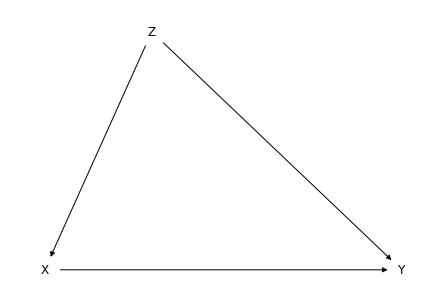

In [103]:
G = nx.DiGraph()
G.graph['dpi'] = 120

nodes = ['X', 'Y', 'Z']
edges = [('Z','X'), ('Z','Y'), ('X','Y')]
nodes_pos = {'Z':(-.7, 1), 'X':(-1, -1), 'Y':(0, -1)}
nodes_lbl = {'Z':'Z', 'X':'X', 'Y':'Y'}

G.add_nodes_from(nodes)
G.add_edges_from(edges)
nx.draw(G,nodes_pos,node_size=800,node_color='white')
_ = nx.draw_networkx_labels(G,nodes_pos,nodes_lbl)

Notice that, alternatively, we may imagine gender as an observable proxy for a deeper confounder related to those social factors that may make an individual more or less apt at a given discipline.

## Implementation

Let us simulate an instance of Simpson's paradox using the same setup we used for the greedy casino.

In [104]:
def random_select_gender():
    return np.random.binomial(1,p=.5)

def select_admissionrate(gender):
    if gender==0:
        return np.array([.62,.63,.37,.33,.28,.06])
    else:
        return np.array([.82,.68,.34,.35,.24,.07])
    
def apply(department,admissionrate):
    return np.random.binomial(1,admissionrate[department])

def observational_select_department(gender):
    if gender==0:
        return np.random.choice(range(6),p=[.31,.21,.12,.15,.07,.14])
    else:
        return np.random.choice(range(6),p=[.06,.02,.3,.21,.22,.19])

The function for selecting the gender of the applicant is analogous to functions *random_select_blinking()* or *random_select_drunkedness()*. The selection of admission rate corresponds to the *sneaky_select_reward()* function (although the current function is not sneaky in itself). The apply function, which returns the outcome of the application (0: *rejection*, 1: *acceptance*), takes the place of the *play()* function before. Finally we have an observational simulation function; this assumes that the students have a *natural* distribution of choice of departments, similarly to what happened in the *observational_select_lever()* function.

## Observational study

Let us bring all together to instantiate an observational simulation.

In [105]:
def run_observational_simulation(n_trials=n_trials):
    
    results = {'gender': np.zeros(n_trials), 
               'department': np.zeros(n_trials), 
               'outcome': np.zeros(n_trials)}
    
    for i in tqdm(range(n_trials)):
        gender = random_select_gender()
        
        admissionrate = select_admissionrate(gender)
                
        department = observational_select_department(gender)
            
        outcome = apply(department,admissionrate)
        
        results['gender'][i] = gender
        results['department'][i] = department
        results['outcome'][i] = outcome
    
    return results

Let us collect a set of samples.

In [106]:
obs_res = run_observational_simulation()

100%|██████████████████████████████████| 10000/10000 [00:00<00:00, 72033.17it/s]


Let us look then at the probability of admission $P(Y=1)$, as well as the probability of admission conditioned on gender, $P(Y=1 \vert Z=male)$ and $P(Y=1 \vert Z=female)$.

In [107]:
print('Probability of admission: {0}'.format(np.sum(obs_res['outcome']==1) / len(obs_res['outcome'])))

Probability of admission: 0.3813


In [108]:
print('Probability of male admission: {0}'.format(np.sum(np.logical_and(obs_res['outcome']==1,obs_res['gender']==0)) / np.sum(obs_res['gender']==0)))

Probability of male admission: 0.44402239104358254


In [109]:
print('Probability of female admission: {0}'.format(np.sum(np.logical_and(obs_res['outcome']==1,obs_res['gender']==1)) / np.sum(obs_res['gender']==1)))

Probability of female admission: 0.31852741096438575


Probability of male admission is greater than female admission.

Let us now look at the breakdown by department, that is, $P(Y=1 \vert Z=male, X=dept_i)$ and $P(Y=1 \vert Z=female, X=dept_i)$

In [110]:
obs_male_admission_per_dept = []
for i in range(6):
    n_success_dept = np.sum(obs_res['outcome'][np.logical_and(obs_res['department']==i,obs_res['gender']==0)])
    n_dept = np.sum(np.logical_and(obs_res['department']==i,obs_res['gender']==0))

    obs_male_admission_per_dept.append(n_success_dept / n_dept)
    print('Probability of male admission given department {0}: {1}'.format(i, n_success_dept / n_dept)) 

Probability of male admission given department 0: 0.6064030131826742
Probability of male admission given department 1: 0.6447761194029851
Probability of male admission given department 2: 0.3547854785478548
Probability of male admission given department 3: 0.34805890227576974
Probability of male admission given department 4: 0.25210084033613445
Probability of male admission given department 5: 0.06051873198847262


In [111]:
obs_female_admission_per_dept = []
for i in range(6):
    n_success_dept = np.sum(obs_res['outcome'][np.logical_and(obs_res['department']==i,obs_res['gender']==1)])
    n_dept = np.sum(np.logical_and(obs_res['department']==i,obs_res['gender']==1))

    obs_female_admission_per_dept.append(n_success_dept / n_dept)
    print('Probability of female admission given department {0}: {1}'.format(i, n_success_dept / n_dept)) 

Probability of female admission given department 0: 0.8390092879256966
Probability of female admission given department 1: 0.6082474226804123
Probability of female admission given department 2: 0.3567251461988304
Probability of female admission given department 3: 0.34001910219675263
Probability of female admission given department 4: 0.25757575757575757
Probability of female admission given department 5: 0.09081196581196581


Let us plot these results for easier interpretation:

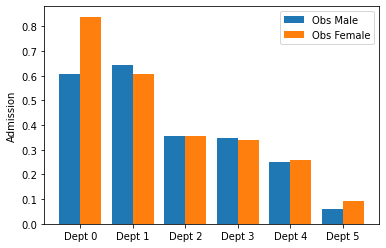

In [112]:
xaxis = np.arange(6)
xlabels = ['Dept 0','Dept 1','Dept 2','Dept 3','Dept 4','Dept 5']  
  
plt.bar(xaxis - 0.2, obs_male_admission_per_dept, 0.4, label = 'Obs Male')
plt.bar(xaxis + 0.2, obs_female_admission_per_dept, 0.4, label = 'Obs Female')
  
plt.xticks(xaxis, xlabels)
plt.ylabel("Admission")
plt.legend()
plt.show()

In almost all departments, female applicants have a higher acceptance rate.

How do we deal with this apparent inconsistency? It easy to explain it with respect to the underlying causal model:

- In our first analysis we just considered $P(Y \vert Z)$: this allowed us to study the causal relationship between gender and acceptance, accounting for both directed and mediated effects; however, this does not describe explicitly how the choice of the department affects the result.

- In the second analysis we studied $P(Y \vert Z,X)$: this allowed us to perform a stratified study and see how the causal relationship between gender and acceptance varies at different levels of the department value. 

# Conclusion

Through all the scenarios above (casinos, medicines, university) we had the opportunity of seeing different aspects of confounding.

First of all, we have seen *different types of confounders*:
- Observable confounders: like in the case of gender in *Simposon's paradox*;
- Unobservable confounders: like in the case of socio-economic status in *Effectiveness of a new medicine*.
In between, we have dealt with unobservable confounders that are partially observable, at least from one party (like level of blinking in the *Greedy casino*), or which can be estimated via a proxy (like income in the *Policymaking for a new medicine*).

We have carried out *different types of studies* which provided us with different information:
- Observational studies: providing a description of the overall behaviour of the system, aggregating together casual effects ($X \rightarrow Y$) and confounding effects ($Z \rightarrow Y$), as well as the possible interaction effect between causes and confounders ($X,Z \rightarrow Y$).
- Interventional studies: providing a description only of casual effects ($X \rightarrow Y$) by performing experiments and interventions.
- Do-calculus studies: computing interventional quantities from observational data without performing experiments.
- Policymaking studies: aimed at dealing not only with the casual effects ($X \rightarrow Y$), but also taking into account the role of confounding ($Z \rightarrow Y$,$X,Z \rightarrow Y$) when enacting a policy.
- Conditional interventional studies: eliciting knowledge about the effects of a confounder ($Z$) through the observation of proxy variables ($W$) and leading us to estimate stratified causal effects.
- Counterfactual studies: assessing the effect of interventions by considering the actual world alongside alternative counterfactual realities.

Formally, we have analyzed *different quantities*:
- Average treatment effects (ATE): $P(Y\vert do(X=1)) - P(Y\vert do(X=0))$
- Conditional treatment effects (CATE): $P(Y\vert do(X=1),W) - P(Y\vert do(X=0),W)$
- Individual treatment effects (ITE): $P_{X=0}(Y=1 \vert do(X=1)) - P(Y=1 \vert do(X=0))$

Exploring all these aspects hopefully offered a wider view and perspective on confounders, their meaning and their role in causal inference. 

## References

\[Bareinboim2015\] Bareinboim, Elias, Andrew Forney, and Judea Pearl. "Bandits with unobserved confounders: A causal approach." Advances in Neural Information Processing Systems 28 (2015): 1342-1350.

\[Pearl2009\] Pearl, Judea. Causality. Cambridge university press, 2009.

# Appendix

Further examples are provided here in appendix.

## One-confounder example

This example shows that we can have a situation similar to the greedy casino illustrated above with a single confounding variable ($Z$).

In [113]:
def Z():
    return np.random.binomial(1,p=.8)

def R(z):
    if z==0:
        return np.array([.1,.5])
    else:
        return np.array([.5,.1])

def X(z):
    return z

def doX():
    return np.random.binomial(1,p=.5)
    
def Y(x,r):
    return np.random.binomial(1,r[int(x)])

In [114]:
def run_observational_simulation(n_trials=1000):
    
    results = {'x': np.zeros(n_trials),
               'z': np.zeros(n_trials),
               'y': np.zeros(n_trials)}
    
    for i in tqdm(range(n_trials)):
        z = Z()
        r = R(z)
        x = X(z)
        y = Y(x,r) 
        
        results['x'][i] = x
        results['z'][i] = z
        results['y'][i] = y
    
    return results

res = run_observational_simulation()
print('Probability of victory: {0}'.format(np.sum(res['y']==1) / len(res['y'])))

100%|███████████████████████████████████| 1000/1000 [00:00<00:00, 268246.61it/s]

Probability of victory: 0.102


In [115]:
def run_interventional_simulation(n_trials=1000):
    
    results = {'x': np.zeros(n_trials),
               'z': np.zeros(n_trials),
               'y': np.zeros(n_trials)}
    
    for i in tqdm(range(n_trials)):
        z = Z()
        r = R(z)
        x = doX()
        y = Y(x,r) 
        
        results['x'][i] = x
        results['z'][i] = z
        results['y'][i] = y
    
    return results

res = run_interventional_simulation()
print('Probability of victory: {0}'.format(np.sum(res['y']==1) / len(res['y'])))

100%|███████████████████████████████████| 1000/1000 [00:00<00:00, 195775.95it/s]

Probability of victory: 0.268


## Maximally greedy casino example

This example shows that a maximally-greedy casino may min-max the rewards to minimize the observational return and still have a legitimate-looking interventional return.

In [116]:
def Z1():
    return np.random.binomial(1,p=.5)

def Z2():
    return np.random.binomial(1,p=.5)

def R(z1,z2):
    if z2==0:
        if z1==0:
            return np.array([.01,.59])
        else:
            return np.array([.59,.01])
    else:
        if z1==0:
            return np.array([.59,.01])
        else:
            return np.array([.01,.59])

def X(z1,z2):
    return np.logical_xor(z1,z2)

def doX():
    return np.random.binomial(1,p=.5)
    
def Y(x,r):
    return np.random.binomial(1,r[int(x)])

In [117]:
def run_observational_simulation(n_trials=1000):
    
    results = {'x': np.zeros(n_trials),
               'y': np.zeros(n_trials)}
    
    for i in tqdm(range(n_trials)):
        z1 = Z1(); z2 = Z2()
        r = R(z1,z2)
        x = X(z1,z2)
        y = Y(x,r) 
        
        results['x'][i] = x
        results['y'][i] = y
    
    return results

res = run_observational_simulation()
print('Probability of victory: {0}'.format(np.sum(res['y']==1) / len(res['y'])))

100%|███████████████████████████████████| 1000/1000 [00:00<00:00, 169412.07it/s]

Probability of victory: 0.013


In [118]:
def run_interventional_simulation(n_trials=1000):
    
    results = {'x': np.zeros(n_trials),
               'y': np.zeros(n_trials)}
    
    for i in tqdm(range(n_trials)):
        z1 = Z1(); z2 = Z2()
        r = R(z1,z2)
        x = doX()
        y = Y(x,r) 
        
        results['x'][i] = x
        results['y'][i] = y
    
    return results

res = run_interventional_simulation()
print('Probability of victory: {0}'.format(np.sum(res['y']==1) / len(res['y'])))

100%|███████████████████████████████████| 1000/1000 [00:00<00:00, 156009.08it/s]

Probability of victory: 0.289


## CATE sensitivity example

Let us analyze how the sensitivity of CATE depends on how reliably our proxy represent the unobserved confounder. We will consider a parameter $p$ denoting the probability that the proxy (*income*) and the unobserved confounder (*socio-economic status*) agree. We consider a range of values for $p$.

In [119]:
p = np.arange(0.1,1.1,0.1)

We define a parametric *income()* function that depends on the value of $p$.

In [120]:
def income(status,p):
    if status==0:
        return np.random.binomial(1,1-p)
    else:
        return np.random.binomial(1,p)
    
def recovery(medicine,status):
    if status==0:
        if medicine==0:
            return np.random.binomial(1,.4)
        else:
            return np.random.binomial(1,.25)
    else:
        if medicine==0:
            return np.random.binomial(1,.4)
        else:
            return np.random.binomial(1,.45)

Then we instantiate a versatile CATE simulation that receives in input the value of $p$ and the value of an intervention.

In [121]:
def run_CATE_simulation(n_trials=n_trials,p=.9,intervention=0):
    
    results = {'x': np.zeros(n_trials),
               'z': np.zeros(n_trials),
               'y': np.zeros(n_trials),
               'w': np.zeros(n_trials)}
    
    for i in tqdm(range(n_trials)):
        status = SEstatus()
        proxy = income(status,p)
        medicine = intervention            
        outcome = recovery(medicine,status)
        
        results['x'][i] = medicine
        results['z'][i] = status
        results['y'][i] = outcome
        results['w'][i] = proxy
    
    return results

We run our simulation for all the values of $p$ and for the two possible interventions, estimating the value of the CATE.

In [122]:
ps = np.arange(0.1,1.1,0.1)
cates0 = []
cates1 = []

for p in ps:
    int0_results = run_CATE_simulation(n_trials,p,0)
    int1_results = run_CATE_simulation(n_trials,p,1)
    
    P_doX0_givenW0 = np.sum(np.logical_and(int0_results['y']==1,int0_results['w']==0)) / np.sum(int0_results['w']==0)
    P_doX0_givenW1 = np.sum(np.logical_and(int0_results['y']==1,int0_results['w']==1)) / np.sum(int0_results['w']==1)
    
    P_doX1_givenW0 = np.sum(np.logical_and(int1_results['y']==1,int1_results['w']==0)) / np.sum(int1_results['w']==0)
    P_doX1_givenW1 = np.sum(np.logical_and(int1_results['y']==1,int1_results['w']==1)) / np.sum(int1_results['w']==1)

    cate0 = P_doX1_givenW0 - P_doX0_givenW0
    cate1 = P_doX1_givenW1 - P_doX0_givenW1
    
    cates0.append(cate0)
    cates1.append(cate1)


100%|█████████████████████████████████| 10000/10000 [00:00<00:00, 222016.00it/s]


Finally, we plot our results, together with the true value of the causal effect at the two different levels of the socio-economic status ($Z$) variable.

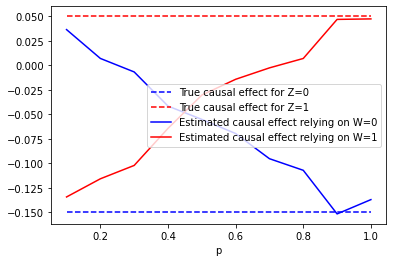

In [123]:
true_P_givenZ0 = [.25 - .4]*len(ps)
true_P_givenZ1 = [.45 - .4]*len(ps)

plt.plot(ps,true_P_givenZ0,c='blue',linestyle='dashed',label='True causal effect for Z=0')
plt.plot(ps,true_P_givenZ1,c='red',linestyle='dashed',label='True causal effect for Z=1')

plt.plot(ps,cates0,c='blue',label='Estimated causal effect relying on W=0')
plt.plot(ps,cates1,c='red',label='Estimated causal effect relying on W=1')

plt.xlabel('p')
plt.legend()

As expected, the more faithful the income ($W$) variable is to the socio-economic status ($Z$), that is the higher is $p$, the closer is our estimation to the true causal effect.